In [1]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import tokenizer_from_json

sequence_length = 13
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/model_llm.keras"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/texts_test.csv"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/tokenizer_config.json"
# /content/drive/MyDrive/metar/LECOmodel_llm.keras
#/content/drive/MyDrive/metar/LECOtokenizer_config.json
#/content/drive/MyDrive/Colab Notebooks/gpt/LECO/texts_test.csv

model_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/LECOml.keras"
texts_test_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/notebooks/LECOtexts_testml.csv"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/LECOtokenizerml.json"
result_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/notebooks/LECOresultml.csv"


model = load_model(model_path)
texts_test = pd.read_csv(texts_test_path, index_col="time").squeeze()

# Load the JSON configuration from the file
with open(tokenizer_path, 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Rebuild tokenizer from the JSON configuration
tokenizer = tokenizer_from_json(tokenizer_json)

In [2]:
#@title Get: X test, Y test and y_pred

sample = 300

# Function to generate text
def generate_text(seed_text, next_words=6):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted_probs = model.predict(token_list,verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        seed_text += " " + predicted_word
    return seed_text

def get_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Join the first n words back into a string
    return ' '.join(words[:n])

def delete_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Remove the first n words
    del words[:n]
    # Join the remaining words back into a string
    return ' '.join(words)

def delete_words_beyond_nosig(input_string):
    # Split the string into words
    words = input_string.split()
    # Find the index of "nosig" if it exists
    try:
        index_nosig = words.index("nosig")
    except ValueError:
        # If "nosig" is not found, return the original string
        return input_string
    # Keep only the words before "nosig"
    return ' '.join(words[:index_nosig + 1])


text_test = texts_test.sample(sample)

#texts_test.to_csv("/content/drive/MyDrive/Colab Notebooks/gpt/Levx/texts_test")

all_for_text = []
y_test = []
y_pred = []

for i in range(len(text_test)):
  all_for_text.append(generate_text(get_first_n_words(text_test[i],8),11))
  y_test.append(delete_first_n_words(text_test[i], 8))
  y_pred.append(delete_words_beyond_nosig(delete_first_n_words(all_for_text[i], 8)))

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred,"all":all_for_text})
result.index=text_test.index
result.to_csv(result_path)
result
for ind in range(0,len(result)):
  display(result.iloc[ind]["y_test"])
  display(result.iloc[ind]["y_pred"])
  display(result.iloc[ind]["all"])
  #display(result.iloc[ind]["all"])
  print("*********")

'16005KT 120V210 9999 BKN038 15/15 Q1015 TEMPO 3000 RA'

'vrb02kt 9999 ra bkn033 16 15 q1015 nosig'

'17009kt 5000 RA BKN040 BKN 16 14 q1015 vrb02kt 9999 ra bkn033 16 15 q1015 nosig tempo ra bkn010'

*********


'20005KT 170V230 9999 FEW024 17/15 Q1014 TEMPO 3000 RA'

'19004kt 9999 few022 16 15 q1015 nosig'

'18003kt 9999 WM FEW025 M 17 16 q1015 19004kt 9999 few022 16 15 q1015 nosig tempo 3000 br bkn002'

*********


'21012KT 160V260 9999 FEW030 14/01 Q1010 NOSIG'

'20013kt 160v230 9999 few045 14 14 q1011 nosig'

'19007kt 9999 WM M050 M 13 02 q1011 20013kt 160v230 9999 few045 14 14 q1011 nosig 2000 ra bkn014'

*********


'VRB02KT CAVOK 22/16 Q1019 NOSIG'

'vrb01kt cavok 24 13 q1020 nosig'

'06003kt 9999 WM MNClD M 22 16 q1020 vrb01kt cavok 24 13 q1020 nosig bkn012 20 rwy tempo sct010'

*********


'27008KT 230V310 9999 FEW020 SCT030 11/09 Q1024 NOSIG'

'31006kt 250v010 9999 sct022 12 09 q1024 nosig'

'28011kt 9999 WM SCT025 SCT 12 09 q1024 31006kt 250v010 9999 sct022 12 09 q1024 nosig q1024 nosig 3000'

*********


'04005KT CAVOK 25/18 Q1016 NOSIG'

'07008kt 010v110 cavok 24 19 q1017 nosig'

'02003kt 9999 WM MNClD M 24 18 q1016 07008kt 010v110 cavok 24 19 q1017 nosig few040 26 q1016 nosig'

*********


'28010KT 240V320 9999 SCT030TCU 08/05 Q0995 RESHRA TEMPO SHRA'

'28012kt 240v330 9999 sct030 06 04 q0993 tempo 3000 shra sct030tcu'

'26017kt 9999 WM SCT030 M 07 04 q0995 28012kt 240v330 9999 sct030 06 04 q0993 tempo 3000 shra sct030tcu'

*********


'03005KT 340V060 9999 SCT032 10/07 Q1031 NOSIG'

'36005kt 300v060 9999 bkn033 11 07 q1032 nosig'

'03005kt 9999 WM BKN035 M 11 07 q1032 36005kt 300v060 9999 bkn033 11 07 q1032 nosig nsw nosig r03'

*********


'36004KT 320V030 9999 FEW012 BKN025 18/16 Q1020 NOSIG'

'36004kt 320v050 9999 few015 21 18 q1020 nosig'

'34001kt 9999 WM FEW015 BKN 19 16 q1020 36004kt 320v050 9999 few015 21 18 q1020 nosig sct030 16 12'

*********


'VRB02KT 9999 FEW040 18/14 Q1013 NOSIG'

'vrb02kt 9999 few035 18 15 q1013 nosig'

'15001kt 9999 WM FEWNClD M 16 15 q1013 vrb02kt 9999 few035 18 15 q1013 nosig few030tcu nosig 20 12'

*********


'20008KT 170V230 9999 FEW030 10/08 Q1015 NOSIG'

'23003kt 170v300 9999 few030 11 08 q1015 tempo 3000 ra bkn010'

'23009kt 9999 WM FEW030 M 10 08 q1015 23003kt 170v300 9999 few030 11 08 q1015 tempo 3000 ra bkn010'

*********


'23024G38KT 200V290 2500 +SHRA SCT026TCU BKN048 14/12 Q0999 NOSIG'

'20007kt 3000 ra bkn026 14 13 q1001 2000n bcfg bkn040 8000'

'21017kt 3000 RA SCT030 SCT 16 12 q0999 20007kt 3000 ra bkn026 14 13 q1001 2000n bcfg bkn040 8000'

*********


'24004KT 210V280 9999 FEW026 13/07 Q1024 NOSIG'

'26005kt 9999 sct025 11 09 q1024 nosig'

'25005kt 9999 WM FEW030 M 10 06 q1024 26005kt 9999 sct025 11 09 q1024 nosig q1026 nosig ra sct005'

*********


'22013G23KT 190V250 9999 SCT030 20/15 Q1012 NOSIG'

'19010kt 160v220 9999 sct030 21 13 q1013 nosig'

'19007kt 9999 WM SCT030 M 20 13 q1013 19010kt 160v220 9999 sct030 21 13 q1013 nosig sct030 21 16'

*********


'02010KT 340V080 9999 SCT020 BKN045 10/05 Q1025 NOSIG'

'02010kt 340v060 9999 sct030tcu bkn045 11 05 q1025 nosig'

'00013kt 9999 WM SCT025 BKN 10 04 q1025 02010kt 340v060 9999 sct030tcu bkn045 11 05 q1025 nosig tempo ra'

*********


'VRB02KT 8000 2700 NSC 13/11 Q1020'

'vrb02kt 9000 ra few002 bkn032 ovc049 12 12 q1020 tempo 3000'

'04001kt 9999 WM NSC045 M 12 12 q1020 vrb02kt 9000 ra few002 bkn032 ovc049 12 12 q1020 tempo 3000'

*********


'22023G37KT 190V250 9999 FEW030 16/14 Q1013 TEMPO RA'

'21010kt 9999 sct028 bkn038 18 15 q1013 nosig'

'20021kt 9999 WM SCT030 BKN 17 14 q1013 21010kt 9999 sct028 bkn038 18 15 q1013 nosig 3000 ra few030tcu'

*********


'13005KT 080V190 9999 BKN032 12/09 Q1013 NOSIG'

'22013kt 9999 few030 14 08 q1011 nosig'

'14007kt 9999 WM BKN030 M 13 09 q1012 22013kt 9999 few030 14 08 q1011 nosig 3000 ra br bkn012'

*********


'VRB02KT 9999 FEW040 07/05 Q1027 NOSIG'

'12003kt 090v150 9999 few040 09 04 q1027 nosig'

'19011kt 9999 WM FEW040 M 09 04 q1027 12003kt 090v150 9999 few040 09 04 q1027 nosig 3000 ra br'

*********


'02005KT 330V060 9999 FEW012 BKN021 18/14 Q1017 NOSIG'

'04006kt 220v330 9999 ovc006 17 16 q1018 tempo 1500 bcfg bkn002'

'30005kt 9999 WM OVC010 BKN 18 15 q1018 04006kt 220v330 9999 ovc006 17 16 q1018 tempo 1500 bcfg bkn002'

*********


'VRB02KT 9999 BCFG FEW030 08/08 Q1024 TEMPO 0800 BCFG BKN005'

'00000kt 9999 few023 10 09 q1024 nosig'

'13001kt 9999 FG FEW030 M 08 08 q1024 00000kt 9999 few023 10 09 q1024 nosig 3000 ra br bkn010'

*********


'24005KT 150V290 4000 DZ BKN015 BKN022 17/17 Q1012 TEMPO 2500 RA'

'27008kt 9999 bkn021 bkn040 18 15 q1012 nosig'

'25009kt 9999 DZ BKN015 BKN 16 15 q1013 27008kt 9999 bkn021 bkn040 18 15 q1012 nosig 3000 ra bkn014'

*********


'15005KT 110V190 9000 -SHRA FEW022 SCT030TCU BKN036 20/17 Q1016 NOSIG'

'19005kt 160v220 9999 ra few022 sct049 19 18 q1016 tempo 3000'

'17005kt 9999 RA FEW025 SCT 18 17 q1016 19005kt 160v220 9999 ra few022 sct049 19 18 q1016 tempo 3000'

*********


'00000KT 9999 BKN016 06/04 Q0985 NOSIG'

'vrb03kt 9999 bkn015 07 06 q1013 nosig'

'23001kt 9999 WM BKN020 M 06 05 q0985 vrb03kt 9999 bkn015 07 06 q1013 nosig vv001 08 05 q1013'

*********


'15004KT 110V170 8000 VCFG OVC018 16/16 Q1021 NOSIG'

'vrb02kt 9999 bkn018 18 15 q1020 nosig'

'16001kt 9999 FG FEW020 M 18 14 q1020 vrb02kt 9999 bkn018 18 15 q1020 nosig 3000 br bkn014 16'

*********


'29011G21KT 240V010 9999 BKN025TCU 09/04 Q1001 TEMPO SHRA SCT025TCU'

'33018g31kt 280v010 9999 sct030tcu 09 04 q1002 tempo shra sct030tcu 09'

'28015kt 9999 WM SCT030 M 09 04 q1002 33018g31kt 280v010 9999 sct030tcu 09 04 q1002 tempo shra sct030tcu 09'

*********


'36005KT 300V060 9999 SCT017 BKN040 21/18 Q1018 TEMPO BKN010'

'01004kt 330v080 9999 sct028 23 17 q1018 nosig'

'06003kt 9999 WM SCT020 BKN 22 17 q1018 01004kt 330v080 9999 sct028 23 17 q1018 nosig 3000 tempo 3000'

*********


'01010KT 300V060 CAVOK 17/12 Q1014'

'35013kt 320v060 8000 nsc 17 14 q1014 tempo 3000 ra bkn010'

'34011kt 9999 WM MNClD M 16 13 q1014 35013kt 320v060 8000 nsc 17 14 q1014 tempo 3000 ra bkn010'

*********


'29016G34KT 230V350 9999 -RA SCT035 BKN044 14/09 Q1013 WS R03 TEMPO RA'

'19005kt 140v230 9999 sct030 bkn040 14 10 q1012 nosig'

'25019kt 9999 WM SCT030 SCT 14 09 q1012 19005kt 140v230 9999 sct030 bkn040 14 10 q1012 nosig 3000 ra'

*********


'30009KT 230V340 9999 FEW023 14/12 Q1012'

'32010kt 260v020 9999 sct021 bkn035 13 12 q1013 tempo 1500 bcfg'

'27013kt 9999 WM SCT020 BKN 14 12 q1012 32010kt 260v020 9999 sct021 bkn035 13 12 q1013 tempo 1500 bcfg'

*********


'36006KT 300V070 9999 OVC028 19/16 Q1020'

'01007kt 320v080 9999 sct025 19 15 q1020 nosig'

'03007kt 9999 WM OVC020 OVC 19 16 q1020 01007kt 320v080 9999 sct025 19 15 q1020 nosig 3000 ra bkn014'

*********


'24006KT 200V300 9999 FEW035 17/10 Q1014 NOSIG'

'22006kt 160v270 9999 few040 16 10 q1015 nosig'

'25013kt 9999 WM FEW040 M 15 09 q1015 22006kt 160v270 9999 few040 16 10 q1015 nosig q1015 nosig q1018'

*********


'VRB01KT 9999 SCT035 07/05 Q1009 TEMPO SHRA SCT020TCU'

'34010g21kt 310v010 9999 sct037 09 04 q1009 tempo 3000 shra sct025tcu'

'02011kt 9999 WM FEW040 SCT 08 04 q1009 34010g21kt 310v010 9999 sct037 09 04 q1009 tempo 3000 shra sct025tcu'

*********


'05013KT 020V100 CAVOK 24/12 Q1026'

'03011kt 340v080 cavok 22 11 q1026 nosig'

'02013kt 9999 WM MNClD M 22 12 q1026 03011kt 340v080 cavok 22 11 q1026 nosig q1027 nosig tempo ra'

*********


'35009KT 310V070 9999 FEW040 22/14 Q1025 NOSIG'

'32007kt 250v020 9999 few040 24 15 q1024 nosig'

'30009kt 9999 WM FEW040 M 21 15 q1024 32007kt 250v020 9999 few040 24 15 q1024 nosig q1026 q1023 nosig'

*********


'VRB02KT CAVOK 08/07 Q1027 NOSIG'

'17005kt cavok 09 08 q1026 nosig'

'16005kt 9999 WM MNClD M 09 07 q1026 17005kt cavok 09 08 q1026 nosig q1027 nosig 11 05 q1027'

*********


'16008KT CAVOK 01/M01 Q1026 NOSIG'

'16006kt cavok 03 01 q1026 nosig'

'18007kt 9999 WM MNClD M 00 00 q1026 16006kt cavok 03 01 q1026 nosig q1027 nosig q1027 nosig q1027'

*********


'17004KT 9999 SCT024 BKN035 13/13 Q1015 NOSIG'

'19006kt 9999 sct023 sct032 14 12 q1014 nosig'

'17001kt 9999 WM FEW025 BKN 14 12 q1015 19006kt 9999 sct023 sct032 14 12 q1014 nosig tempo 3000 ra'

*********


'18003KT 0200 R21/0350N R03/0375U FG BKN001 09/09 Q1027 TEMPO 1500 BCFG'

'17003kt 0200 r21 0300n r03 0250n fg vv001 10 10 q1026'

'18001kt 800 FG VV005 M 10 09 q1026 17003kt 0200 r21 0300n r03 0250n fg vv001 10 10 q1026'

*********


'27003KT 230V310 9999 SCT035 11/08 Q1020 NOSIG'

'00000kt 9999 few030 10 08 q1019 nosig'

'30003kt 9999 WM FEW030 M 10 08 q1019 00000kt 9999 few030 10 08 q1019 nosig few040 17 q1021 rera'

*********


'07009KT CAVOK 11/04 Q1030 NOSIG'

'35009kt 300v060 cavok 11 04 q1031 nosig'

'04007kt 9999 WM MNClD M 11 04 q1031 35009kt 300v060 cavok 11 04 q1031 nosig q1026 nosig q1029 nosig'

*********


'16006KT CAVOK 06/03 Q1029 NOSIG'

'vrb01kt cavok 06 05 q1029 nosig'

'21003kt 9999 WM MNClD M 06 03 q1029 vrb01kt cavok 06 05 q1029 nosig 3000 shra ts sct020cb 06'

*********


'24006KT 190V280 9999 FEW022 BKN033 BKN048 16/16 Q1027'

'24008kt 200v260 9999 sct018 15 13 q1028 nosig'

'22007kt 9999 WM FEW020 M 14 14 q1027 24008kt 200v260 9999 sct018 15 13 q1028 nosig bkn044 15 11'

*********


'20019G36KT 160V240 7000 -RA FEW015 BKN026 BKN040 15/13 Q1000 NOSIG'

'19020g33kt 160v230 9999 ra few017 bkn022 15 13 q0999 tempo 4000'

'20021kt 9999 RA FEW015 BKN 14 13 q1000 19020g33kt 160v230 9999 ra few017 bkn022 15 13 q0999 tempo 4000'

*********


'35009KT 300V060 7000 -RA BKN013 13/13 Q1016 TEMPO 3000'

'35007kt 300v040 9999 bkn011 bkn020 14 14 q1016 nosig'

'00009kt 9999 RA BKN015 BKN 14 13 q1016 35007kt 300v040 9999 bkn011 bkn020 14 14 q1016 nosig tempo 3000'

*********


'20010KT 9999 FEW030 19/15 Q1015 NOSIG'

'16005kt 9999 few030 18 15 q1015 nosig'

'20005kt 9999 WM FEW030 M 19 16 q1015 16005kt 9999 few030 18 15 q1015 nosig tempo 3000 br bkn002'

*********


'VRB01KT 9999 FEW020 SCT032 BKN046 18/14 Q1021 NOSIG'

'vrb02kt 9999 few005 bkn007 17 17 q1020 nosig'

'29003kt 9999 WM FEW005 BKN 17 14 q1020 vrb02kt 9999 few005 bkn007 17 17 q1020 nosig tempo ra bkn014'

*********


'17005KT 9999 OVC041 17/15 Q1023'

'vrb02kt cavok 15 15 q1022 nosig'

'13005kt 9999 WM MNClD M 15 14 q1022 vrb02kt cavok 15 15 q1022 nosig ovc039 16 10 q1023 nosig'

*********


'20014KT 170V240 CAVOK 11/07 Q1019 NOSIG'

'18011kt cavok 12 07 q1020 nosig'

'18015kt 9999 WM MNClD M 11 08 q1020 18011kt cavok 12 07 q1020 nosig sct044 11 q1021 nosig sct049'

*********


'34005KT 280V050 9999 FEW030 25/19 Q1015 NOSIG'

'02009kt 350v060 cavok 22 17 q1014 nosig'

'28009kt 9999 WM MNClD M 24 17 q1015 02009kt 350v060 cavok 22 17 q1014 nosig nosig nosig 20 20'

*********


'35009KT 280V030 CAVOK 21/14 Q1024 NOSIG'

'30005kt 250v360 cavok 19 13 q1023 nosig'

'33009kt 9999 WM MNClD M 19 14 q1024 30005kt 250v360 cavok 19 13 q1023 nosig sct030cb 17 15 q1023'

*********


'17006KT CAVOK 16/15 Q1017'

'vrb01kt cavok 18 15 q1017 nosig'

'15005kt 9999 WM MNClD M 17 15 q1017 vrb01kt cavok 18 15 q1017 nosig sct044 16 14 q1018 nosig'

*********


'00000KT 8000 3900E BCFG FEW004 BKN048 15/14 Q1011 NOSIG'

'vrb01kt 0500 r21 p2000 r03 0800u fg bkn005 bkn008 13 13'

'18001kt 9999 FG FEW010 BKN 13 13 q1011 vrb01kt 0500 r21 p2000 r03 0800u fg bkn005 bkn008 13 13'

*********


'19002KT 7000 2000 NCD 05/04 Q1024'

'17006kt 9999 ncd 04 03 q1023 nosig'

'14007kt 9999 WM NCDNClD M 06 04 q1024 17006kt 9999 ncd 04 03 q1023 nosig tempo ovc040 3000 ra'

*********


'01005KT 310V110 9999 SCT028 11/04 Q1020 NOSIG'

'04008kt 9999 sct039 10 04 q1019 tempo shra sct030tcu 07 03'

'02011kt 9999 WM SCT040 M 10 04 q1020 04008kt 9999 sct039 10 04 q1019 tempo shra sct030tcu 07 03'

*********


'19016G28KT 140V220 9999 BKN030 19/14 Q1010 NOSIG'

'19012kt 9999 few029 19 14 q1011 nosig'

'19015kt 9999 WM BKN030 M 18 14 q1011 19012kt 9999 few029 19 14 q1011 nosig nosig 19 15 q1011'

*********


'15005KT CAVOK 09/07 Q1023 NOSIG'

'18002kt cavok 09 08 q1024 nosig'

'12003kt 9999 WM MNClD M 09 07 q1023 18002kt cavok 09 08 q1024 nosig 3000 br bkn025 06 05'

*********


'VRB01KT 9999 0800E BCFG NSC 15/15 Q1020 NOSIG'

'vrb02kt 9999 vcfg nsc 15 15 q1020 nosig'

'14003kt 9999 FG NSCNClD M 17 14 q1020 vrb02kt 9999 vcfg nsc 15 15 q1020 nosig 3000 bcfg few001'

*********


'21011KT 170V230 CAVOK 17/07 Q1026 NOSIG'

'13007kt cavok 15 09 q1027 nosig'

'12003kt 9999 WM MNClD M 15 07 q1026 13007kt cavok 15 09 q1027 nosig q1027 08 06 q1026 tempo'

*********


'05010KT 350V090 9999 FEW046 16/05 Q1025 NOSIG'

'05011kt 010v090 9999 few045 15 06 q1025 nosig'

'03011kt 9999 WM FEW050 M 14 05 q1025 05011kt 010v090 9999 few045 15 06 q1025 nosig 4000 ra sct025tcu'

*********


'VRB03KT CAVOK 07/M01 Q1029'

'06003kt 080v170 cavok 03 m00 q1029 nosig'

'11003kt 9999 WM MNClD M 04 00 q1029 06003kt 080v170 cavok 03 m00 q1029 nosig 4000 0500se r21 tempo'

*********


'00000KT 6000 0400E R21/0300N R03/0800D BCFG MIFG NSC 02/02 Q1014 TEMPO 0500 BCFG'

'18004kt 130v210 5000 bcfg nsc 02 02 q1015 nosig'

'08001kt 9999 FG NSCNClD M 04 02 q1015 18004kt 130v210 5000 bcfg nsc 02 02 q1015 nosig tempo 3000'

*********


'VRB04KT CAVOK 18/17 Q1016'

'vrb02kt cavok 18 16 q1014 nosig'

'09003kt 9999 WM MNClD M 18 16 q1014 vrb02kt cavok 18 16 q1014 nosig 3000 br bkn001 16 15'

*********


'31005KT 260V020 9999 SCT027TCU 11/08 Q1009 TEMPO 3000 SHRA'

'31008kt 230v360 9999 sct025tcu 08 07 q1009 reshra tempo 3000 shra'

'30011kt 9999 WM SCT030 BKN 10 06 q1009 31008kt 230v360 9999 sct025tcu 08 07 q1009 reshra tempo 3000 shra'

*********


'28006KT 230V330 CAVOK 15/13 Q1014'

'26008kt 220v310 9999 few026 sct030 bkn042 18 13 q1014 tempo 3000'

'26011kt 9999 WM SCT030 SCT 16 13 q1014 26008kt 220v310 9999 few026 sct030 bkn042 18 13 q1014 tempo 3000'

*********


'27006KT 210V310 9999 SCT030 14/08 Q1021 NOSIG'

'29005kt 230v340 9999 few030 16 10 q1022 nosig'

'24009kt 9999 WM FEW030 M 15 08 q1022 29005kt 230v340 9999 few030 16 10 q1022 nosig sct030 12 q1022'

*********


'03007KT 340V080 9999 BKN035 21/13 Q1027 NOSIG'

'01011kt 320v070 9999 sct040 19 13 q1027 nosig'

'03009kt 9999 WM FEW040 M 20 13 q1027 01011kt 320v070 9999 sct040 19 13 q1027 nosig q1027 16 10'

*********


'VRB02KT 9999 SCT025 13/09 Q1019 NOSIG'

'01007kt 320v050 9999 few030 14 09 q1019 nosig'

'35005kt 9999 WM FEW030 M 13 08 q1019 01007kt 320v050 9999 few030 14 09 q1019 nosig 3000 ra bkn010'

*********


'17003KT 5000 2000 BCFG NSC 05/05 Q1034 TEMPO 3000 BCFG'

'18004kt 0300 r21 0550n r03 0550n fg nsc 03 03 q1034'

'16005kt 800 FG NSCNClD M 06 05 q1034 18004kt 0300 r21 0550n r03 0550n fg nsc 03 03 q1034'

*********


'05007KT 020V080 CAVOK 08/01 Q1032 NOSIG'

'34006kt 300v010 cavok 10 m00 q1032 nosig'

'03007kt 9999 WM MNClD M 09 01 q1032 34006kt 300v010 cavok 10 m00 q1032 nosig 2000 nosig shra sct030tcu'

*********


'16003KT CAVOK 17/14 Q1018 NOSIG'

'vrb02kt cavok 16 14 q1018 nosig'

'27003kt 9999 WM MNClD M 16 14 q1018 vrb02kt cavok 16 14 q1018 nosig 3000 br bkn001 bkn005 17'

*********


'36005KT 320V050 CAVOK 26/18 Q1018 NOSIG'

'36005kt 310v060 cavok 26 17 q1016 nosig'

'05005kt 9999 WM MNClD M 26 17 q1017 36005kt 310v060 cavok 26 17 q1016 nosig tempo ra bkn014 20'

*********


'36008KT 300V050 9999 FEW030 12/08 Q1011 NOSIG'

'26007kt 210v300 9999 few027 13 08 q1011 nosig'

'33007kt 9999 WM FEW030 M 13 09 q1011 26007kt 210v300 9999 few027 13 08 q1011 nosig 3000 ra bkn014'

*********


'21009KT 9999 BKN046 14/11 Q1024 NOSIG'

'18004kt 9999 few048 12 10 q1023 nosig'

'22005kt 9999 WM BKN050 SCT 14 12 q1023 18004kt 9999 few048 12 10 q1023 nosig q1026 nosig q1027 nosig'

*********


'33002KT CAVOK 17/15 Q1018'

'vrb02kt cavok 18 15 q1018 nosig'

'10003kt 9999 WM MNClD M 17 15 q1018 vrb02kt cavok 18 15 q1018 nosig bkn018 18 15 q1018 nosig'

*********


'03008KT 340V060 9999 FEW035 16/10 Q1026 NOSIG'

'05004kt 020v090 9999 few035 sct045 15 07 q1026 nosig'

'00007kt 9999 WM FEW040 M 16 09 q1026 05004kt 020v090 9999 few035 sct045 15 07 q1026 nosig q1027 nosig'

*********


'VRB01KT CAVOK 15/12 Q1025 NOSIG'

'17003kt 140v200 cavok 14 11 q1025 nosig'

'19003kt 9999 WM MNClD M 16 12 q1025 17003kt 140v200 cavok 14 11 q1025 nosig q1026 nosig few030tcu 16'

*********


'34010KT 280V030 9999 FEW026 21/15 Q1019 NOSIG'

'01008kt 330v060 9999 few030 21 13 q1019 nosig'

'33007kt 9999 WM FEW030 M 19 14 q1019 01008kt 330v060 9999 few030 21 13 q1019 nosig 3000 radz sct017'

*********


'27005KT 230V330 9999 SCT024 SCT048 14/11 Q1019 NOSIG'

'33006kt 280v030 9999 few006 sct020 bkn040 12 10 q1021 tempo shra'

'29007kt 9999 WM SCT010 SCT 13 10 q1019 33006kt 280v030 9999 few006 sct020 bkn040 12 10 q1021 tempo shra'

*********


'36003KT 330V030 9999 NCD 19/16 Q1016'

'00000kt 9999 ncd 16 15 q1015 nosig'

'02001kt 9999 WM NCDNClD M 17 16 q1016 00000kt 9999 ncd 16 15 q1015 nosig 3000 ra bkn010 16'

*********


'22008KT 200V260 9999 FEW038/// 09/07 Q1006'

'26010kt 210v300 9999 sct045 11 06 q1007 tempo 3000 ra bkn014'

'27015kt 9999 WM FEW040 M 10 06 q1007 26010kt 210v300 9999 sct045 11 06 q1007 tempo 3000 ra bkn014'

*********


'20004KT 160V230 9999 BKN028 17/15 Q1020 NOSIG'

'vrb02kt 9999 bkn030 18 15 q1020 nosig'

'34001kt 9999 WM BKN030 M 17 15 q1020 vrb02kt 9999 bkn030 18 15 q1020 nosig 3000 bcfg bkn014 17'

*********


'21018G29KT 170V250 9999 -RA SCT035TCU 11/09 Q1008 TEMPO 3000 SHRA SCT025TCU'

'25009kt 220v310 9999 ra sct035 bkn045 11 09 q1011 tempo 3000'

'21019kt 9999 RA FEW040 M 10 09 q1009 25009kt 220v310 9999 ra sct035 bkn045 11 09 q1011 tempo 3000'

*********


'VRB02KT 8000 NSC 11/11 Q1019 TEMPO 3000 BR'

'vrb02kt 8000 nsc 11 10 q1019 nosig'

'00001kt 9999 WM NSCNClD M 11 11 q1019 vrb02kt 8000 nsc 11 10 q1019 nosig 3000 br bkn002 bkn014'

*********


'06010KT 350V110 9999 FEW035 SCT049 21/13 Q1027 NOSIG'

'vrb02kt 9999 few035 21 14 q1026 nosig'

'02005kt 9999 WM FEW040 SCT 20 13 q1027 vrb02kt 9999 few035 21 14 q1026 nosig q1027 nosig tempo ra'

*********


'36003KT 320V020 9999 FEW022 BKN040 09/06 Q1002 NOSIG'

'00000kt 9999 few020 08 08 q1003 tempo shra sct025tcu 08 07'

'01003kt 9999 WM FEW025 BKN 09 07 q1003 00000kt 9999 few020 08 08 q1003 tempo shra sct025tcu 08 07'

*********


'36011G21KT 320V050 9999 FEW040 18/12 Q1012 NOSIG'

'05005kt 350v080 9999 few035 18 10 q1013 nosig'

'00011kt 9999 WM M040 M 18 12 q1013 05005kt 350v080 9999 few035 18 10 q1013 nosig 3000 ra sct005'

*********


'33003KT 280V020 9999 SCT032 SCT046 10/06 Q1019'

'36014kt 320v050 9999 sct034 12 07 q1019 nosig'

'35013kt 9999 WM SCT035 M 10 05 q1019 36014kt 320v050 9999 sct034 12 07 q1019 nosig few040 16 05'

*********


'04005KT 350V100 9999 FEW020 23/18 Q1017 NOSIG'

'33007kt 260v010 9999 few024 21 17 q1018 nosig'

'29007kt 9999 WM FEW025 M 22 17 q1017 33007kt 260v010 9999 few024 21 17 q1018 nosig sct008 17 17'

*********


'03007KT 350V060 CAVOK 27/21 Q1018 NOSIG'

'36008kt 300v030 cavok 31 22 q1018 nosig'

'32007kt 9999 WM MNClD M 28 20 q1018 36008kt 300v030 cavok 31 22 q1018 nosig 3000 br bkn012 240v010'

*********


'00000KT CAVOK 24/17 Q1019 NOSIG'

'13005kt cavok 23 16 q1019 nosig'

'13003kt 9999 WM MNClD M 23 17 q1019 13005kt cavok 23 16 q1019 nosig 3000 tsra few050cb 21 20'

*********


'21004KT 9999 FEW034 19/16 Q1016 NOSIG'

'vrb02kt 9999 few030 18 15 q1015 nosig'

'35001kt 9999 WM FEW030 M 18 16 q1015 vrb02kt 9999 few030 18 15 q1015 nosig tempo 3000 br bkn002'

*********


'32015G32KT 260V020 9999 FEW040 09/05 Q1003 RESHRA TEMPO 3000 SHRA SCT030TCU'

'32014g24kt 250v010 9999 sct035tcu sct045 07 04 q1003 tempo shra sct025tcu'

'29017kt 9999 WM SCT040 M 08 04 q1003 32014g24kt 250v010 9999 sct035tcu sct045 07 04 q1003 tempo shra sct025tcu'

*********


'15005KT 090V200 9999 FEW025 SCT029 FEW035TCU BKN047 23/19 Q1007 NOSIG'

'vrb05kt 9999 few030tcu sct045 22 19 q1011 nosig'

'21007kt 9999 WM FEW030 SCT 22 19 q1007 vrb05kt 9999 few030tcu sct045 22 19 q1011 nosig 3000 shra sct030cb'

*********


'00000KT CAVOK 16/15 Q1024 NOSIG'

'vrb01kt cavok 18 15 q1024 nosig'

'34003kt 9999 WM MNClD M 17 16 q1024 vrb01kt cavok 18 15 q1024 nosig nosig nosig fg bkn001 15'

*********


'02006KT 340V070 9999 FEW035 25/20 Q1020 NOSIG'

'33007kt 250v010 9999 few032 24 19 q1020 nosig'

'31009kt 9999 WM FEW035 M 24 18 q1020 33007kt 250v010 9999 few032 24 19 q1020 nosig 3000 br bkn002'

*********


'16004KT 9999 BKN024 11/09 Q1023 NOSIG'

'18004kt 9999 sct026 11 10 q1024 nosig'

'25005kt 9999 WM FEW030 M 11 09 q1023 18004kt 9999 sct026 11 10 q1024 nosig q1026 tempo ra bkn010'

*********


'20011KT 150V230 9999 BKN020 19/17 Q1020 NOSIG'

'21015kt 9999 ra bkn040 19 18 q1004 nosig'

'21013kt 9999 RA BKN025 M 19 17 q1019 21015kt 9999 ra bkn040 19 18 q1004 nosig 18 17 q1019'

*********


'19006KT 140V230 9999 FEW020 BKN032 17/15 Q1005 NOSIG'

'21013kt 9999 few030tcu bkn040 16 13 q1006 tempo ra bkn033 15'

'21007kt 9999 WM FEW030 BKN 16 13 q1006 21013kt 9999 few030tcu bkn040 16 13 q1006 tempo ra bkn033 15'

*********


'32002KT CAVOK 15/13 Q1020'

'vrb01kt cavok 15 14 q1020 nosig'

'11005kt 9999 WM MNClD M 15 14 q1020 vrb01kt cavok 15 14 q1020 nosig 3000 shra 23009kt sct030 17'

*********


'34004KT 290V050 7000 FEW002 SCT006 BKN013 18/18 Q1017 TEMPO BKN015'

'17004kt 9000 sct009 bkn008 bkn016 18 18 q1017 tempo bkn010 bkn020tcu'

'27011kt 9999 WM SCT005 BKN 20 17 q1017 17004kt 9000 sct009 bkn008 bkn016 18 18 q1017 tempo bkn010 bkn020tcu'

*********


'19002KT CAVOK 14/14 Q1013'

'17006kt 9999 ncd 14 14 q1013 nosig'

'18005kt 9999 WM NCDNClD M 15 15 q1013 17006kt 9999 ncd 14 14 q1013 nosig vv001 17 15 q1013'

*********


'02005KT 340V060 CAVOK 19/07 Q1028 NOSIG'

'36003kt 300v080 cavok 17 10 q1028 nosig'

'36003kt 9999 WM MNClD M 17 08 q1028 36003kt 300v080 cavok 17 10 q1028 nosig 7000 nosig ra bkn031'

*********


'33007KT 260V010 9999 SCT034 09/06 Q1014 TEMPO 3000 TSGR SCT030CB'

'32016g30kt 9999 few035 09 07 q1015 tempo 3000 ra bkn014 rera'

'30013kt 9999 WM SCT040 M 10 06 q1014 32016g30kt 9999 few035 09 07 q1015 tempo 3000 ra bkn014 rera'

*********


'01007KT 300V080 9999 FEW016 SCT040 23/18 Q1017 NOSIG'

'03008kt 330v070 9999 few030 21 17 q1016 nosig'

'32007kt 9999 WM FEW030 M 22 17 q1016 03008kt 330v070 9999 few030 21 17 q1016 nosig ts r03 ra'

*********


'34006KT 310V020 9999 FEW009 SCT021 14/13 Q1015 TEMPO BKN010'

'vrb02kt 9999 few005 sct027 15 15 q1016 nosig'

'29003kt 9999 WM FEW010 SCT 14 13 q1016 vrb02kt 9999 few005 sct027 15 15 q1016 nosig tempo ra bkn014'

*********


'VRB02KT 9999 -SHRA SCT035TCU 05/03 Q1023 NOSIG'

'vrb02kt 9999 sct030tcu 08 04 q1023 tempo 3000 shra sct025tcu 05'

'28003kt 9999 RA SCT040 BKN 06 04 q1023 vrb02kt 9999 sct030tcu 08 04 q1023 tempo 3000 shra sct025tcu 05'

*********


'00000KT CAVOK 18/13 Q1021 NOSIG'

'00000kt cavok 19 13 q1022 nosig'

'12001kt 9999 WM MNClD M 18 13 q1022 00000kt cavok 19 13 q1022 nosig nosig nosig 18 15 q1022'

*********


'VRB02KT 9999 FEW035 12/12 Q1025 NOSIG'

'01004kt 330v060 9999 few030 12 09 q1024 nosig'

'03005kt 9999 WM FEWNClD M 12 09 q1024 01004kt 330v060 9999 few030 12 09 q1024 nosig q1025 nosig nosig'

*********


'19007KT CAVOK 05/03 Q1024 NOSIG'

'17005kt 4200 0150sw r03 0650n br br bcfg nsc 05 05'

'15005kt 800 FG NSCNClD M 05 05 q1024 17005kt 4200 0150sw r03 0650n br br bcfg nsc 05 05'

*********


'16008KT CAVOK 13/05 Q1029 NOSIG'

'34003kt 160v280 cavok 14 07 q1029 nosig'

'14009kt 9999 WM MNClD M 13 06 q1029 34003kt 160v280 cavok 14 07 q1029 nosig 3000 nosig few030tcu sct045'

*********


'VRB02KT 9999 FEW004 SCT026 18/17 Q1008 NOSIG'

'14004kt 9999 bkn025 20 15 q1007 nosig'

'25003kt 9999 WM FEW010 M 19 16 q1008 14004kt 9999 bkn025 20 15 q1007 nosig bkn038 21 16 q1008'

*********


'02003KT 340V050 3000 -DZ BR FEW005 BKN008 BKN011 14/13 Q1015 REDZ NOSIG'

'35009kt 320v050 3000 br sct004 bkn010 12 10 q1016 tempo bkn008'

'34005kt 3000 DZ FEW005 BKN 12 11 q1016 35009kt 320v050 3000 br sct004 bkn010 12 10 q1016 tempo bkn008'

*********


'02003KT 340V050 9999 BKN029 13/11 Q1002 NOSIG'

'36003kt 330v040 9999 bkn030 12 10 q1003 nosig'

'02005kt 9999 WM BKN030 M 12 11 q1003 36003kt 330v040 9999 bkn030 12 10 q1003 nosig 8000 4000s bcfg'

*********


'17003KT 140V200 9999 BCFG NSC 16/16 Q1023 TEMPO 1400 BCFG'

'vrb02kt 9999 3000s bcfg few001 16 16 q1024 nosig'

'20003kt 9999 FG NSC005 M 18 17 q1023 vrb02kt 9999 3000s bcfg few001 16 16 q1024 nosig nsw bkn014'

*********


'24008KT 210V280 9000 SCT026 SCT040 17/15 Q1009 NOSIG'

'19007kt 9999 sct016 bkn038 15 15 q1011 nosig'

'23009kt 9999 WM FEW020 BKN 16 15 q1010 19007kt 9999 sct016 bkn038 15 15 q1011 nosig 3000 ra br'

*********


'08007KT 040V130 CAVOK 14/11 Q1006'

'36007kt 320v050 9999 few030 14 12 q1006 nosig'

'02007kt 9999 WM FEW030 M 14 12 q1006 36007kt 320v050 9999 few030 14 12 q1006 nosig 3000 ra bkn010'

*********


'VRB01KT 9999 FEW035 20/16 Q1016 NOSIG'

'vrb01kt 9999 few040 18 15 q1016 nosig'

'17003kt 9999 WM M040 M 18 14 q1016 vrb01kt 9999 few040 18 15 q1016 nosig sct007 15 15 q1017'

*********


'27010KT 210V330 9999 SCT044 14/05 Q1014 NOSIG'

'33008kt 240v020 9999 sct045 12 04 q1015 tempo ra bkn014 16'

'27009kt 9999 WM SCT050 M 12 05 q1015 33008kt 240v020 9999 sct045 12 04 q1015 tempo ra bkn014 16'

*********


'21015G25KT 170V250 9999 -SHRA SCT030TCU SCT044 15/12 Q1010 TEMPO 4000 SHRA SCT035TCU'

'18014kt 140v210 9999 few025 sct040 17 13 q1007 nosig'

'17011kt 9999 WM FEW030 M 15 11 q1009 18014kt 140v210 9999 few025 sct040 17 13 q1007 nosig q1007 sct035'

*********


'01007KT 310V050 CAVOK 21/15 Q1020 NOSIG'

'01007kt 320v070 9999 few020 22 16 q1020 nosig'

'34007kt 9999 WM FEW030 M 21 15 q1020 01007kt 320v070 9999 few020 22 16 q1020 nosig few040 21 17'

*********


'20003KT 180V250 CAVOK 17/15 Q1020 NOSIG'

'vrb01kt cavok 18 15 q1019 nosig'

'02003kt 9999 WM MNClD M 17 15 q1019 vrb01kt cavok 18 15 q1019 nosig 3000 tsra bkn015 few030tcu 17'

*********


'VRB02KT 1600 1400SW RA BR SCT022 BKN027 BKN034 08/08 Q1018'

'vrb01kt 9999 sct030 06 06 q1016 tempo ra bkn013 bkn020 08'

'36003kt 9999 WM SCT030 BKN 08 07 q1017 vrb01kt 9999 sct030 06 06 q1016 tempo ra bkn013 bkn020 08'

*********


'VRB02KT CAVOK 16/12 Q1022'

'36003kt cavok 15 12 q1023 nosig'

'03003kt 9999 WM MNClD M 15 12 q1022 36003kt cavok 15 12 q1023 nosig tempo br bkn012 16 16'

*********


'VRB01KT 6000 SCT005 BKN009 15/15 Q1026 TEMPO SCT010'

'34003kt 310v040 9999 sct005 bkn010 15 13 q1028 becmg 3000 br'

'02001kt 9999 WM SCT005 M 14 14 q1027 34003kt 310v040 9999 sct005 bkn010 15 13 q1028 becmg 3000 br'

*********


'02004KT 340V060 CAVOK 18/16 Q1017 NOSIG'

'00000kt cavok 20 16 q1017 nosig'

'30003kt 9999 WM MNClD M 19 16 q1017 00000kt cavok 20 16 q1017 nosig bkn012 23 fg nosig bkn014'

*********


'20014G24KT 160V230 5000 RA SCT022 BKN032 13/11 Q0998 TEMPO RA'

'20009kt 160v240 9999 ra few025 sct034 bkn041 15 12 q0998 rera'

'22013kt 9999 RA FEW030 BKN 14 11 q0997 20009kt 160v240 9999 ra few025 sct034 bkn041 15 12 q0998 rera'

*********


'VRB02KT 9999 BKN047 15/12 Q1020'

'vrb02kt 9999 bkn048 15 12 q1019 nosig'

'30005kt 9999 WM BKN050 M 15 12 q1020 vrb02kt 9999 bkn048 15 12 q1019 nosig tempo tempo 3000 ra'

*********


'16005KT CAVOK 11/06 Q1019 NOSIG'

'16006kt 120v210 9999 few030 12 08 q1020 nosig'

'14007kt 9999 WM MNClD M 11 07 q1020 16006kt 120v210 9999 few030 12 08 q1020 nosig sct007 bkn014 ra'

*********


'03006KT 330V070 9999 FEW020 SCT040 13/08 Q1030 NOSIG'

'03008kt 350v080 9999 few040 12 07 q1030 nosig'

'02011kt 9999 WM FEW040 BKN 12 07 q1030 03008kt 350v080 9999 few040 12 07 q1030 nosig 4000 ra bkn014'

*********


'13005KT CAVOK 14/12 Q1017'

'21010kt cavok 15 10 q1017 nosig'

'18009kt 9999 WM MNClD M 13 11 q1017 21010kt cavok 15 10 q1017 nosig sct044 16 06 q1016 nosig'

*********


'25005KT 220V290 9999 FEW020 19/18 Q1017 NOSIG'

'26003kt 9999 few020 18 15 q1018 nosig'

'23007kt 9999 WM FEW025 M 18 16 q1018 26003kt 9999 few020 18 15 q1018 nosig 3000 br bkn025 16'

*********


'16006KT 140V200 9000 DZ FEW011 BKN045 11/10 Q1010 TEMPO 3000 SHRA SCT030TCU'

'21018kt 5000 ra br sct010 bkn014 bkn020 12 12 q1010 tempo'

'21013kt 9999 DZ FEW015 BKN 12 10 q1010 21018kt 5000 ra br sct010 bkn014 bkn020 12 12 q1010 tempo'

*********


'36005KT 310V050 9999 FEW030 23/18 Q1017 NOSIG'

'36007kt 290v060 9999 few030 bkn041 24 17 q1017 nosig'

'01007kt 9999 WM FEW030 M 22 18 q1017 36007kt 290v060 9999 few030 bkn041 24 17 q1017 nosig nosig nosig'

*********


'33009KT 290V030 9999 SCT011 BKN017 15/12 Q1015 TEMPO BKN012'

'31010kt 250v010 9999 bkn013 bkn030 14 11 q1016 tempo 3000 ra'

'28011kt 9999 WM BKN015 BKN 16 11 q1016 31010kt 250v010 9999 bkn013 bkn030 14 11 q1016 tempo 3000 ra'

*********


'VRB02KT CAVOK 23/16 Q1015 NOSIG'

'03010kt 360v060 cavok 19 17 q1016 nosig'

'30007kt 9999 WM MNClD M 20 16 q1016 03010kt 360v060 cavok 19 17 q1016 nosig bkn012 nosig 19 19'

*********


'17005KT 140V210 9999 FEW033 BKN045 19/18 Q1016 NOSIG'

'21009kt 9999 bkn033 19 16 q1015 nosig'

'21005kt 9999 WM BKN035 BKN 19 18 q1015 21009kt 9999 bkn033 19 16 q1015 nosig 3000 ra bkn010 16'

*********


'16005KT 110V190 CAVOK 06/05 Q1026 NOSIG'

'16004kt cavok 08 04 q1026 nosig'

'16005kt 9999 WM MNClD M 07 04 q1026 16004kt cavok 08 04 q1026 nosig q1026 nosig 33009kt nosig 08'

*********


'35004KT 290V050 9999 FEW028 11/07 Q1037 NOSIG'

'vrb02kt 9999 few026 08 07 q1037 nosig'

'08005kt 9999 WM FEW030 M 09 07 q1036 vrb02kt 9999 few026 08 07 q1037 nosig 3000 ra sct028 bkn038'

*********


'VRB02KT CAVOK 13/06 Q1029 NOSIG'

'20004kt 150v250 cavok 14 07 q1030 nosig'

'16003kt 9999 WM MNClD M 14 05 q1030 20004kt 150v250 cavok 14 07 q1030 nosig bkn012 nosig 05 05'

*********


'36008KT 280V060 9999 FEW024 15/10 Q1011 NOSIG'

'23010kt 150v260 9999 few049 14 09 q1009 nosig'

'03013kt 9999 WM FEWNClD M 14 08 q1010 23010kt 150v260 9999 few049 14 09 q1009 nosig 2000 tempo ra'

*********


'18004KT 150V210 9999 NCD 15/12 Q1009'

'17010kt 130v220 9999 ncd 15 13 q1008 nosig'

'19005kt 9999 WM NCDNClD M 15 13 q1009 17010kt 130v220 9999 ncd 15 13 q1008 nosig 1500 ra bkn014'

*********


'04004KT 350V080 9999 FEW030 18/13 Q1021 NOSIG'

'01004kt 330v060 9999 few030 17 14 q1021 nosig'

'02005kt 9999 WM FEW030 M 17 13 q1021 01004kt 330v060 9999 few030 17 14 q1021 nosig 3000 shra sct030tcu'

*********


'17007KT CAVOK 07/05 Q1028 NOSIG'

'17005kt cavok 06 05 q1028 nosig'

'18007kt 9999 WM MNClD M 07 04 q1028 17005kt cavok 06 05 q1028 nosig 3000 prfg 3000 br bcfg'

*********


'34003KT 9999 3000NE VCFG FEW009 17/17 Q1019 TEMPO 3000 BR'

'vrb02kt 9999 sct036 18 15 q1019 nosig'

'02001kt 9999 FG FEW010 M 17 16 q1020 vrb02kt 9999 sct036 18 15 q1019 nosig 3000 br bkn002 bkn008'

*********


'36004KT 280V070 9999 FEW011 SCT014 BKN020 21/18 Q1017 NOSIG'

'vrb02kt 9999 bkn010 bkn020 19 19 q1019 nosig'

'28005kt 9999 WM BKN015 BKN 19 17 q1018 vrb02kt 9999 bkn010 bkn020 19 19 q1019 nosig tempo 3000 br'

*********


'36006KT 300V080 9999 BKN022 19/16 Q1019 NOSIG'

'01006kt 330v060 9999 few020 20 16 q1019 nosig'

'35007kt 9999 WM FEW025 M 19 15 q1019 01006kt 330v060 9999 few020 20 16 q1019 nosig 3000 tsra sct025cb'

*********


'05005KT CAVOK 07/02 Q1034 NOSIG'

'06004kt cavok 06 02 q1034 nosig'

'06003kt 9999 WM MNClD M 06 02 q1034 06004kt cavok 06 02 q1034 nosig vv001 08 02 q1034 tempo'

*********


'26006KT 230V290 9000 -RA SCT030 07/04 Q1013 TEMPO SHRA SCT030TCU'

'30004kt 260v340 9999 few030tcu sct035 07 05 q1011 tempo shra sct030tcu'

'28009kt 9999 WM SCT030 SCT 07 04 q1012 30004kt 260v340 9999 few030tcu sct035 07 05 q1011 tempo shra sct030tcu'

*********


'22008KT 9999 FEW025TCU 05/04 Q1006 TEMPO SHRA SCT025TCU'

'23008kt 9999 few030 05 03 q1007 tempo shra sct025tcu 05 05'

'23007kt 9999 WM FEW030 M 06 03 q1006 23008kt 9999 few030 05 03 q1007 tempo shra sct025tcu 05 05'

*********


'22009KT CAVOK 17/16 Q1021'

'vrb02kt 9999 few020 17 16 q1021 nosig'

'19003kt 9999 WM M025 M 17 15 q1021 vrb02kt 9999 few020 17 16 q1021 nosig 3000 tempo ra bkn010'

*********


'35008KT 310V050 9999 FEW025 19/16 Q1023 NOSIG'

'36007kt 310v050 cavok 20 15 q1023 nosig'

'36005kt 9999 WM FEWNClD M 19 15 q1023 36007kt 310v050 cavok 20 15 q1023 nosig q1027 nosig few030tcu nosig'

*********


'35005KT 300V030 CAVOK 20/11 Q1024 NOSIG'

'02005kt 330v060 cavok 20 13 q1023 nosig'

'31005kt 9999 WM MNClD M 19 13 q1023 02005kt 330v060 cavok 20 13 q1023 nosig q1027 nosig ra tempo'

*********


'16003KT 4600 -RA BR NSC 12/12 Q1014'

'vrb02kt cavok 14 13 q1012 nosig'

'21001kt 5000 RA NSCNClD M 13 12 q1013 vrb02kt cavok 14 13 q1012 nosig bkn043 17 15 q1013 nosig'

*********


'17011G22KT 140V200 9999 FEW020 12/08 Q1002'

'15005kt 120v210 9999 few016 sct030 11 08 q1003 nosig'

'15009kt 9999 WM FEW020 M 11 09 q1003 15005kt 120v210 9999 few016 sct030 11 08 q1003 nosig 3000 ra'

*********


'34006KT 290V030 CAVOK 27/18 Q1019 NOSIG'

'03008kt 340v080 cavok 26 17 q1020 nosig'

'03009kt 9999 WM MNClD M 26 17 q1020 03008kt 340v080 cavok 26 17 q1020 nosig 3000 br bkn025 bkn045'

*********


'01003KT 330V050 9999 -RA SCT017 BKN022 BKN049 12/11 Q1019 RERA'

'36005kt 320v050 9999 sct020 12 10 q1019 nosig'

'34005kt 9999 WM SCT020 M 11 10 q1019 36005kt 320v050 9999 sct020 12 10 q1019 nosig 3000 ra bkn014'

*********


'01006KT 300V060 9999 SCT019 BKN028 15/14 Q1023 NOSIG'

'02006kt 330v060 9999 few030 14 09 q1024 nosig'

'02009kt 9999 WM FEW030 M 14 09 q1024 02006kt 330v060 9999 few030 14 09 q1024 nosig bkn030 15 06'

*********


'19013G25KT 140V210 9999 FEW020 FEW035TCU SCT036 18/12 Q1002 NOSIG'

'27010kt 220v320 9999 few022 16 15 q1020 nosig'

'21021kt 9999 WM FEW025 SCT 17 13 q1002 27010kt 220v320 9999 few022 16 15 q1020 nosig tempo 3000 ra'

*********


'17004KT 9999 OVC042 15/14 Q1019'

'16004kt 9999 sct044 16 15 q1019 nosig'

'20005kt 9999 WM BKN045 M 15 14 q1019 16004kt 9999 sct044 16 15 q1019 nosig 27019g38kt 130v190 15 14'

*********


'13004KT 100V170 9999 -RA FEW020 SCT040 11/10 Q1005 TEMPO RA'

'14005kt 090v170 9999 sct022 10 08 q1005 nosig'

'17007kt 9999 RA SCT025 SCT 10 08 q1005 14005kt 090v170 9999 sct022 10 08 q1005 nosig 3000 ra bkn010'

*********


'04012KT 330V070 9999 SCT025 BKN039 20/15 Q1019 NOSIG'

'36005kt 320v060 9999 sct025 bkn045 20 15 q1019 nosig'

'03011kt 9999 WM SCT030 BKN 20 15 q1019 36005kt 320v060 9999 sct025 bkn045 20 15 q1019 nosig 3000 radz'

*********


'VRB01KT CAVOK 15/13 Q1018'

'00000kt cavok 14 12 q1018 nosig'

'12003kt 9999 WM MNClD M 14 12 q1018 00000kt cavok 14 12 q1018 nosig 3000 sct030 15 15 q1019'

*********


'VRB02KT 9999 BKN037 21/15 Q1015 NOSIG'

'27005kt 240v320 9999 sct041 20 17 q1015 nosig'

'27005kt 9999 WM M045 M 20 16 q1015 27005kt 240v320 9999 sct041 20 17 q1015 nosig 170v340 tempo 3000'

*********


'VRB08KT 9999 SCT024 15/10 Q1025 NOSIG'

'32009kt 270v040 9999 few024 16 08 q1025 nosig'

'30009kt 9999 WM FEW025 M 15 08 q1026 32009kt 270v040 9999 few024 16 08 q1025 nosig few030tcu 09 08'

*********


'26003KT 210V300 9999 FEW013 SCT016 BKN025 18/16 Q1020 TEMPO 3000 DZ BKN010'

'vrb02kt 9999 bkn012 bkn020 16 15 q1020 tempo bkn014 17 17'

'25003kt 9999 WM BKN015 SCT 17 16 q1020 vrb02kt 9999 bkn012 bkn020 16 15 q1020 tempo bkn014 17 17'

*********


'17007KT 9000 NSC 04/04 Q1031 NOSIG'

'17005kt 8000 r21 1800d r03 0750d bcfg nsc 02 05 q1030'

'20003kt 9999 FG NSCNClD M 03 04 q1031 17005kt 8000 r21 1800d r03 0750d bcfg nsc 02 05 q1030'

*********


'25009KT 220V300 CAVOK 16/12 Q1027 NOSIG'

'22012kt 190v260 cavok 14 10 q1028 nosig'

'21013kt 9999 WM MNClD M 16 11 q1028 22012kt 190v260 cavok 14 10 q1028 nosig 3000 br ra 26009kt'

*********


'26016G29KT 220V310 9999 SCT017 18/13 Q0997 TEMPO 3000 RA BKN010'

'vrb04kt 9999 4000s sct008 sct030tcu 18 15 q1009 tempo shra sct030tcu'

'24015kt 9999 DZ FEW020 SCT 17 14 q0996 vrb04kt 9999 4000s sct008 sct030tcu 18 15 q1009 tempo shra sct030tcu'

*********


'32006KT 250V020 9999 FEW005 20/19 Q1019 NOSIG'

'36006kt 280v080 9999 few005 sct011 bkn018 19 18 q1020 nosig'

'01009kt 9999 WM FEW005 M 23 18 q1019 36006kt 280v080 9999 few005 sct011 bkn018 19 18 q1020 nosig sct006'

*********


'02007KT 330V070 CAVOK 18/12 Q1021 NOSIG'

'36007kt 280v080 9999 few030 17 13 q1021 nosig'

'34007kt 9999 WM MNClD M 18 11 q1021 36007kt 280v080 9999 few030 17 13 q1021 nosig tempo ra bkn010'

*********


'03007KT 330V070 9999 BKN026 19/14 Q1023 NOSIG'

'35006kt 280v040 9999 bkn030 19 15 q1023 nosig'

'04009kt 9999 WM BKN030 BKN 19 15 q1023 35006kt 280v040 9999 bkn030 19 15 q1023 nosig sct030 16 15'

*********


'35011KT 320V050 9999 SCT008 OVC022 14/12 Q1020 TEMPO BKN008'

'36008kt 300v050 9999 sct008 14 12 q1020 nosig'

'35011kt 9999 WM SCT010 OVC 15 11 q1019 36008kt 300v050 9999 sct008 14 12 q1020 nosig nosig 2500 ra'

*********


'13003KT 100V170 9999 FEW030TCU 07/05 Q1007 TEMPO SHRA'

'28006kt 230v290 9999 few030 10 04 q1006 tempo shra sct025tcu 07'

'23003kt 9999 WM FEW030 M 06 05 q1006 28006kt 230v290 9999 few030 10 04 q1006 tempo shra sct025tcu 07'

*********


'VRB02KT 9999 4400 BR NSC 05/05 Q1011'

'00000kt 4500 br nsc 04 04 q1011 nosig'

'26007kt 9999 BR NSC040 BKN 06 04 q1011 00000kt 4500 br nsc 04 04 q1011 nosig sct025cb 04 05'

*********


'18004KT CAVOK 15/14 Q1015'

'18002kt 9999 few045 15 15 q1016 nosig'

'16005kt 9999 WM NSC050 M 15 14 q1016 18002kt 9999 few045 15 15 q1016 nosig sct045 17 15 q1017'

*********


'21006KT 9999 SCT024 BKN034 16/11 Q1024 NOSIG'

'20012kt 160v240 9999 sct022 ovc034 15 09 q1024 nosig'

'21013kt 9999 WM SCT025 BKN 16 10 q1024 20012kt 160v240 9999 sct022 ovc034 15 09 q1024 nosig q1026 5000'

*********


'22008KT 170V260 5000 -RA SCT027 BKN035 14/13 Q1027 TEMPO 3000 RA'

'27012kt 230v310 6000 ra bkn025 bkn037 13 13 q1027 tempo 3000'

'24013kt 9999 RA SCT025 BKN 14 13 q1027 27012kt 230v310 6000 ra bkn025 bkn037 13 13 q1027 tempo 3000'

*********


'19006KT 9000 4000S BCFG NSC M02/M02 Q1033 TEMPO 0800 FZFG'

'19004kt 9999 1500e bcfg nsc m01 m01 q1034 nosig'

'16005kt 9999 FG NSCNClD M -1 -2 q1033 19004kt 9999 1500e bcfg nsc m01 m01 q1034 nosig 3000 1100u'

*********


'36003KT 9999 FEW037 17/13 Q1011 NOSIG'

'36003kt 320v040 cavok 16 14 q1013 nosig'

'00003kt 9999 WM MNClD M 16 14 q1012 36003kt 320v040 cavok 16 14 q1013 nosig 3000 br bkn005 15'

*********


'16003KT 110V210 9999 BCFG FEW003 SCT010 09/08 Q1032 NOSIG'

'00000kt 9999 bcfg few002 sct022 bkn035 07 07 q1032 nosig'

'14005kt 9999 FG FEW005 M 07 06 q1032 00000kt 9999 bcfg few002 sct022 bkn035 07 07 q1032 nosig q1032'

*********


'02005KT 340V060 9999 FEW030 19/13 Q1022 NOSIG'

'35008kt 310v040 9999 bkn026 18 13 q1021 nosig'

'34005kt 9999 WM FEW030 M 19 12 q1021 35008kt 310v040 9999 bkn026 18 13 q1021 nosig nosig tempo 3000'

*********


'VRB01KT CAVOK 16/11 Q1023 NOSIG'

'06005kt cavok 18 11 q1023 nosig'

'04007kt 9999 WM MNClD M 17 11 q1023 06005kt cavok 18 11 q1023 nosig sct044 14 06 q1023 nosig'

*********


'02008KT 330V070 9999 FEW020 13/09 Q1018 NOSIG'

'01007kt 320v060 9999 few023 12 09 q1019 nosig'

'02007kt 9999 WM FEW025 M 13 10 q1019 01007kt 320v060 9999 few023 12 09 q1019 nosig 3000 ra bkn014'

*********


'23013G24KT 200V280 9999 FEW021 BKN040 12/07 Q1004 NOSIG'

'16008kt 110v210 9999 sct021 bkn027 13 08 q1005 nosig'

'20007kt 9999 WM FEW025 BKN 12 08 q1005 16008kt 110v210 9999 sct021 bkn027 13 08 q1005 nosig 3000 ra'

*********


'VRB09G20KT 9999 FEW024 SCT030TCU 17/08 Q1003 TEMPO SHRA'

'23012kt 9999 few022 few035tcu 15 08 q1003 nosig'

'25013kt 9999 WM FEW025 SCT 15 08 q1003 23012kt 9999 few022 few035tcu 15 08 q1003 nosig 3000 ra bkn010'

*********


'26008KT 230V300 CAVOK 15/15 Q1006'

'vrb04kt cavok 16 13 q1008 nosig'

'25005kt 9999 RA MNClD M 14 14 q1007 vrb04kt cavok 16 13 q1008 nosig 3000 ra sct006 few030tcu 15'

*********


'36004KT 320V030 9999 NCD 16/14 Q1017'

'03006kt 350v070 9999 ncd 18 14 q1017 nosig'

'03005kt 9999 WM NCDNClD M 17 14 q1017 03006kt 350v070 9999 ncd 18 14 q1017 nosig 4700 3000 ra'

*********


'VRB01KT 0300 0100SW R21/0750D R03/0325N FG VV/// 13/13 Q1017'

'17002kt 9999 ncd 14 13 q1017 nosig'

'03003kt 800 FG NCDNClD M 15 14 q1017 17002kt 9999 ncd 14 13 q1017 nosig 140v240 12 q1017 nosig'

*********


'20013KT 170V230 9999 FEW034 20/13 Q1014 NOSIG'

'20005kt 130v220 9999 few042 20 15 q1014 tempo 3000 ra bkn014'

'22005kt 9999 WM FEW035 M 20 13 q1014 20005kt 130v220 9999 few042 20 15 q1014 tempo 3000 ra bkn014'

*********


'19010KT 140V240 9999 FEW027 FEW033TCU SCT036 BKN048 16/13 Q1000 TEMPO 3000 SHRA'

'25009kt 200v300 9999 few030 sct045 16 13 q0998 nosig'

'22017kt 9999 WM FEW030 FEW 15 13 q1000 25009kt 200v300 9999 few030 sct045 16 13 q0998 nosig sct048 15'

*********


'25009KT 190V300 9000 BKN020 BKN025 15/11 Q1027 NOSIG'

'23008kt 190v280 9000 bkn012 bkn020 14 13 q1027 nosig'

'24009kt 9999 WM BKN025 BKN 13 11 q1027 23008kt 190v280 9000 bkn012 bkn020 14 13 q1027 nosig rags tempo'

*********


'35017G31KT 280V030 9999 FEW025 BKN042 12/10 Q1021 NOSIG'

'33012kt 280v030 9999 sct030tcu 14 09 q1020 nosig'

'30011kt 9999 WM SCT030 SCT 12 09 q1020 33012kt 280v030 9999 sct030tcu 14 09 q1020 nosig 3000 shra few030cb'

*********


'17004KT 9999 OVC031 07/05 Q1031'

'16004kt 130v190 9999 ovc033 06 06 q1031 nosig'

'18005kt 9999 WM OVC035 M 04 04 q1031 16004kt 130v190 9999 ovc033 06 06 q1031 nosig q1026 tempo ra'

*********


'35004KT 310V030 9999 OVC015 12/10 Q1012'

'17004kt 150v210 4000 br few005 ovc023 12 12 q1012 tempo 1500'

'25003kt 5000 BR OVC015 OVC 12 11 q1012 17004kt 150v210 4000 br few005 ovc023 12 12 q1012 tempo 1500'

*********


'04007KT 360V070 9999 SCT025 22/17 Q1017 NOSIG'

'vrb02kt 9999 sct014 bkn030 19 18 q1018 nosig'

'32005kt 9999 WM SCT015 BKN 20 17 q1018 vrb02kt 9999 sct014 bkn030 19 18 q1018 nosig bkn043 16 17'

*********


'33007KT 260V020 9999 SCT030 19/11 Q1022 NOSIG'

'31005kt 250v020 9999 sct028 18 13 q1022 nosig'

'29007kt 9999 WM SCT030 M 18 12 q1022 31005kt 250v020 9999 sct028 18 13 q1022 nosig tempo ra bkn014'

*********


'20013KT 170V230 9999 SCT028 16/14 Q1019 NOSIG'

'20018kt 170v250 9999 sct026 17 13 q1019 nosig'

'21013kt 9999 WM SCT030 M 16 14 q1019 20018kt 170v250 9999 sct026 17 13 q1019 nosig 3000 ra bkn010'

*********


'34005KT 300V020 9999 FEW020 22/15 Q1019 NOSIG'

'35008kt 300v030 9999 few020 20 16 q1019 nosig'

'35007kt 9999 WM FEW025 M 20 16 q1019 35008kt 300v030 9999 few020 20 16 q1019 nosig 3000 shra bkn014'

*********


'30004KT 230V010 9999 SCT028 BKN033 15/12 Q1019 NOSIG'

'27008kt 230v290 9999 bkn045 13 11 q1019 nosig'

'26005kt 9999 RA BKN050 BKN 14 11 q1019 27008kt 230v290 9999 bkn045 13 11 q1019 nosig sct025tcu 16 15'

*********


'16003KT CAVOK 09/04 Q1017 NOSIG'

'vrb01kt cavok 06 04 q1016 nosig'

'13003kt 9999 WM MNClD M 06 04 q1017 vrb01kt cavok 06 04 q1016 nosig ovc039 05 05 q1017 nosig'

*********


'VRB01KT CAVOK 14/04 Q1032 NOSIG'

'00000kt cavok 14 06 q1032 nosig'

'03001kt 9999 WM MNClD M 13 05 q1032 00000kt cavok 14 06 q1032 nosig bkn042 09 06 q1032 nosig'

*********


'VRB08KT 9999 SCT036 25/15 Q1013 NOSIG'

'19012kt 150v230 9999 sct035tcu sct035tcu sct035 24 14 q1013 tempo 3000'

'27011kt 9999 WM SCT040 M 23 16 q1013 19012kt 150v230 9999 sct035tcu sct035tcu sct035 24 14 q1013 tempo 3000'

*********


'16003KT 120V190 CAVOK 12/08 Q1017 NOSIG'

'13003kt 100v190 9999 few035 12 05 q1017 nosig'

'24003kt 9999 WM FEWNClD M 11 06 q1017 13003kt 100v190 9999 few035 12 05 q1017 nosig ovc039 19 06'

*********


'20014G26KT 170V240 9999 FEW025 26/18 Q1017 NOSIG'

'21013g23kt 170v250 9999 few030 23 15 q1018 nosig'

'20017kt 9999 WM FEW030 M 25 16 q1018 21013g23kt 170v250 9999 few030 23 15 q1018 nosig sct025tcu 19 3000'

*********


'27007KT 240V320 6000 RA BKN025 18/16 Q1027 TEMPO 3000'

'vrb03kt 9999 few025tcu sct034 19 15 q1025 nosig'

'21007kt 9999 RA FEW030 M 18 15 q1025 vrb03kt 9999 few025tcu sct034 19 15 q1025 nosig q1024 q1023 nosig'

*********


'26008G19KT 210V300 9999 FEW034TCU 13/08 Q1003 NOSIG'

'23008kt 190v280 9999 few030 12 07 q1004 nosig'

'25011kt 9999 WM FEW030 M 13 07 q1004 23008kt 190v280 9999 few030 12 07 q1004 nosig 4500 ra bkn014'

*********


'36008KT 310V060 9999 FEW024 20/15 Q1019 NOSIG'

'35012kt 320v030 9999 few040 20 14 q1019 nosig'

'35009kt 9999 WM FEW040 M 20 14 q1019 35012kt 320v030 9999 few040 20 14 q1019 nosig 3000 tempo ra'

*********


'05011KT 010V080 9999 FEW036 11/03 Q1020 NOSIG'

'02008kt 330v070 9999 sct046 11 01 q1020 nosig'

'02011kt 9999 WM SCT050 M 11 03 q1020 02008kt 330v070 9999 sct046 11 01 q1020 nosig 3000 ra bkn014'

*********


'15005KT 120V180 9999 SCT023 SCT034 BKN044 17/14 Q1022'

'vrb08kt 9999 few026 19 14 q1023 nosig'

'27011kt 9999 WM FEW025 M 18 13 q1023 vrb08kt 9999 few026 19 14 q1023 nosig q1024 nosig 15 12'

*********


'18006KT 120V220 9999 -RA FEW025 15/11 Q1017 NOSIG'

'20006kt 9999 few034 16 12 q1019 nosig'

'17005kt 9999 WM FEW035 M 15 12 q1019 20006kt 9999 few034 16 12 q1019 nosig 3000 ra bkn014 16'

*********


'VRB01KT CAVOK 17/08 Q1024 NOSIG'

'00000kt cavok 16 07 q1024 nosig'

'13001kt 9999 WM MNClD M 16 08 q1024 00000kt cavok 16 07 q1024 nosig bkn030 11 06 q1023 nosig'

*********


'01007KT 300V060 9999 FEW025 20/16 Q1019 NOSIG'

'36005kt 300v050 9999 sct020 20 16 q1019 nosig'

'36007kt 9999 WM SCT025 M 20 16 q1019 36005kt 300v050 9999 sct020 20 16 q1019 nosig 3000 ra bkn010'

*********


'16004KT 120V190 9999 OVC019 11/09 Q1028 NOSIG'

'24004kt 210v280 9999 ovc019 12 09 q1028 nosig'

'22005kt 9999 DZ OVC020 OVC 10 09 q1028 24004kt 210v280 9999 ovc019 12 09 q1028 nosig 3000 dz sct028'

*********


'22007KT 190V260 9999 FEW025 SCT045 13/12 Q1010 TEMPO 3000 RA'

'24011g23kt 210v290 9999 few030 12 09 q1011 nosig'

'24011kt 9999 WM FEW030 M 13 10 q1010 24011g23kt 210v290 9999 few030 12 09 q1011 nosig r03 1300u ra'

*********


'18007KT CAVOK 15/10 Q1019 NOSIG'

'18006kt cavok 15 10 q1020 nosig'

'13005kt 9999 WM MNClD M 14 10 q1020 18006kt cavok 15 10 q1020 nosig sct044 17 11 q1020 nosig'

*********


'19015KT 150V230 CAVOK 18/12 Q1016 NOSIG'

'vrb02kt 9999 few030 20 12 q1015 nosig'

'19005kt 9999 WM MNClD M 19 11 q1015 vrb02kt 9999 few030 20 12 q1015 nosig ra bkn025 bkn040 q1018'

*********


'18005KT 9999 0400E R21/1700U R03/P200 BCFG NSC 08/08 Q1019 BECMG 3000 BR'

'17004kt 0500 r21 0600d r03 p2000 fg nsc 09 09 q1018'

'19001kt 800 FG NSCNClD M 09 09 q1019 17004kt 0500 r21 0600d r03 p2000 fg nsc 09 09 q1018'

*********


'22004KT CAVOK 09/07 Q1020 NOSIG'

'20009kt 160v240 9999 bkn025 bkn031 bkn038 10 08 q1020 nosig'

'19007kt 9999 WM BKNNClD BKN 09 08 q1020 20009kt 160v240 9999 bkn025 bkn031 bkn038 10 08 q1020 nosig 5000'

*********


'22005KT 9999 FEW024 SCT036 08/08 Q1017 NOSIG'

'18005kt 9999 bkn024 10 09 q1016 nosig'

'22005kt 9999 WM FEW025 M 10 08 q1016 18005kt 9999 bkn024 10 09 q1016 nosig 3000 ra br bcfg'

*********


'03007KT 360V070 9999 FEW042 SCT045 10/04 Q1009 NOSIG'

'35006kt 300v050 9999 few030tcu 10 06 q1008 nosig'

'04007kt 9999 WM FEW030 M 09 05 q1009 35006kt 300v050 9999 few030tcu 10 06 q1008 nosig 3000 shgs sct030tcu'

*********


'03005KT 350V070 9999 FEW049 17/14 Q1028 NOSIG'

'03008kt 330v080 9999 few020 17 13 q1027 nosig'

'02005kt 9999 WM FEW050 M 16 14 q1027 03008kt 330v080 9999 few020 17 13 q1027 nosig q1027 nosig rwy'

*********


'17018G29KT 140V210 7000 FEW025 SCT032 BKN040 14/12 Q1013'

'18013kt 150v210 9999 ra few030 bkn045 15 12 q1012 tempo 3000'

'18021kt 9999 RA FEW030 M 14 12 q1012 18013kt 150v210 9999 ra few030 bkn045 15 12 q1012 tempo 3000'

*********


'20004KT 9999 BKN025 10/06 Q1007 NOSIG'

'18006kt 9999 few030 08 06 q1007 nosig'

'20005kt 9999 RA FEW030 M 09 05 q1007 18006kt 9999 few030 08 06 q1007 nosig 3000 ra sct028 bkn040'

*********


'19014G25KT 150V230 CAVOK 15/05 Q1022'

'20013g24kt 170v230 cavok 15 06 q1023 nosig'

'17011kt 9999 WM MNClD M 14 07 q1023 20013g24kt 170v230 cavok 15 06 q1023 nosig 3000 shra sct025tcu 08'

*********


'VRB02KT 9000 FEW010 OVC015 11/10 Q1029 TEMPO 3000 BR'

'04002kt 9999 few033 bkn040 11 09 q1030 nosig'

'03003kt 9999 WM FEW015 OVC 09 09 q1030 04002kt 9999 few033 bkn040 11 09 q1030 nosig bkn040 12 10'

*********


'26008KT 9999 -RA FEW037 08/05 Q1004 RERA'

'27006kt 230v320 9999 few035 08 05 q1004 reshgr tempo 3000 shra'

'26009kt 9999 WM FEW040 M 08 04 q1004 27006kt 230v320 9999 few035 08 05 q1004 reshgr tempo 3000 shra'

*********


'03008KT 360V070 9999 SCT037 20/11 Q1020 NOSIG'

'04009kt 350v080 9999 sct040 19 10 q1020 nosig'

'01011kt 9999 WM SCT040 M 20 11 q1020 04009kt 350v080 9999 sct040 19 10 q1020 nosig sct045 19 rwy'

*********


'16006KT 0300 R21/P2000 R03/P2000 BCFG NSC 09/08 Q1022 BECMG 9999'

'19003kt 0200 r21 0650n r03 0325n fg sct001 09 09 q1023'

'19003kt 800 FG NSC005 M 10 09 q1022 19003kt 0200 r21 0650n r03 0325n fg sct001 09 09 q1023'

*********


'35007KT 320V050 9999 FEW025 SCT045 18/11 Q1020 NOSIG'

'03008kt 290v080 9999 few030 18 10 q1020 nosig'

'32007kt 9999 WM FEW030 M 18 11 q1020 03008kt 290v080 9999 few030 18 10 q1020 nosig 4000 ra bkn010'

*********


'VRB01KT 9999 BKN008 13/11 Q1019'

'18002kt cavok 15 11 q1020 nosig'

'21003kt 9999 WM MNClD M 14 11 q1019 18002kt cavok 15 11 q1020 nosig 16 15 q1020 nosig bkn012'

*********


'35007KT 280V080 CAVOK 30/19 Q1014 NOSIG'

'35008kt 300v030 cavok 30 19 q1015 nosig'

'04011kt 9999 WM MNClD M 30 18 q1014 35008kt 300v030 cavok 30 19 q1015 nosig sct006 nosig 18 16'

*********


'05013G23KT 360V070 9999 SCT026 BKN030 18/15 Q1024 NOSIG'

'04012kt 360v080 9999 bkn025 bkn030 19 15 q1024 nosig'

'03009kt 9999 WM BKN030 BKN 18 15 q1024 04012kt 360v080 9999 bkn025 bkn030 19 15 q1024 nosig q1026 nosig'

*********


'21015G31KT 170V250 5000 RA BR FEW026 SCT048 11/10 Q0993'

'22008kt 190v260 9999 ra few030 sct045 11 08 q0995 tempo 3000'

'23013kt 9999 RA FEW030 SCT 11 09 q0994 22008kt 190v260 9999 ra few030 sct045 11 08 q0995 tempo 3000'

*********


'17007KT CAVOK 09/07 Q1021 NOSIG'

'18006kt cavok 10 07 q1020 nosig'

'16005kt 9999 WM MNClD M 10 07 q1020 18006kt cavok 10 07 q1020 nosig bkn001 08 06 q1022 tempo'

*********


'05004KT 020V080 9999 FEW010 BKN015 17/16 Q1019 NOSIG'

'vrb02kt 9999 sct012 bkn035 18 16 q1020 nosig'

'31003kt 9999 WM SCT015 OVC 18 16 q1019 vrb02kt 9999 sct012 bkn035 18 16 q1020 nosig 3000 ra bkn010'

*********


'28009KT 240V320 9999 SCT010 BKN034 07/04 Q0985 NOSIG'

'20019g31kt 9999 few014 300v060 9999 sct022 bkn035 08 05 q0995 nosig'

'28015kt 9999 RA SCT015 BKN 07 04 q0987 20019g31kt 9999 few014 300v060 9999 sct022 bkn035 08 05 q0995 nosig'

*********


'33009KT 290V040 CAVOK 20/15 Q1022 NOSIG'

'36009kt 310v050 cavok 20 14 q1022 nosig'

'34009kt 9999 WM M025 M 20 14 q1022 36009kt 310v050 cavok 20 14 q1022 nosig nosig 20 16 q1022'

*********


'31003KT 220V010 9999 -RA BKN020 BKN026 09/08 Q1020 TEMPO 3000 SHRA SCT025TCU'

'35010kt 250v030 9999 sct022 bkn035 10 06 q1021 nosig'

'33013kt 9999 RA BKN025 SCT 11 06 q1021 35010kt 250v030 9999 sct022 bkn035 10 06 q1021 nosig tempo 3000'

*********


'29006KT 250V330 9999 SCT022 12/09 Q1010 TEMPO RA'

'32012g25kt 260v030 9999 sct020 bkn030 13 09 q1009 tempo 3000 shra'

'29011kt 9999 WM SCT025 SCT 12 10 q1009 32012g25kt 260v030 9999 sct020 bkn030 13 09 q1009 tempo 3000 shra'

*********


'VRB02KT 9999 SCT034 09/08 Q1022 NOSIG'

'vrb02kt 9999 sct034 11 08 q1023 nosig'

'31003kt 9999 WM FEW035 M 10 08 q1023 vrb02kt 9999 sct034 11 08 q1023 nosig q1026 tempo ra bkn010'

*********


'33009KT 280V050 8000 SCT008 BKN013 19/18 Q1021 NOSIG'

'32006kt 260v020 9999 sct022 ovc034 20 19 q1020 nosig'

'29009kt 9999 WM SCT010 BKN 20 18 q1020 32006kt 260v020 9999 sct022 ovc034 20 19 q1020 nosig nosig 6000'

*********


'36007KT 300V060 CAVOK 10/03 Q1021 NOSIG'

'vrb02kt cavok 12 04 q1021 nosig'

'35005kt 9999 WM MNClD M 11 04 q1021 vrb02kt cavok 12 04 q1021 nosig 120v180 bcfg bkn001 11 q1020'

*********


'29002KT 9999 FEW030TCU 12/10 Q1016 TEMPO SHRA'

'34004kt 290v060 9999 few022 12 10 q1016 nosig'

'36005kt 9999 WM FEW030 M 12 10 q1016 34004kt 290v060 9999 few022 12 10 q1016 nosig bkn036 18 15'

*********


'09009KT 060V120 9999 FEW035 17/08 Q1029 NOSIG'

'05009kt 020v090 9999 few040 16 06 q1029 nosig'

'05009kt 9999 WM M040 M 16 07 q1030 05009kt 020v090 9999 few040 16 06 q1029 nosig 3000 ra bkn025'

*********


'17003KT 0200 R21/0375N R03/0300N FG SCT001 06/06 Q1025 NOSIG'

'vrb01kt 9999 sct030 09 08 q1025 nosig'

'07001kt 800 FG SCT030 M 08 08 q1024 vrb01kt 9999 sct030 09 08 q1025 nosig bkn043 08 06 q1024'

*********


'36004KT 320V060 CAVOK 14/10 Q1017'

'02005kt 330v070 cavok 14 10 q1016 nosig'

'34005kt 9999 WM MNClD M 14 10 q1017 02005kt 330v070 cavok 14 10 q1016 nosig sct007 bkn025 15 09'

*********


'23022G37KT 190V280 7000 RA FEW015 BKN030 13/11 Q0992 TEMPO 3000 SHRA SCT015TCU'

'130v220 170v240 9999 ra few010 bkn048 11 09 q0991 tempo 3000'

'19029kt 9999 RA FEW015 BKN 11 08 q0991 130v220 170v240 9999 ra few010 bkn048 11 09 q0991 tempo 3000'

*********


'34006KT 290V060 9999 FEW030 22/19 Q1016 NOSIG'

'02009kt 340v050 9999 few030tcu 21 18 q1015 nosig'

'00007kt 9999 WM FEW030 M 21 17 q1015 02009kt 340v050 9999 few030tcu 21 18 q1015 nosig tempo 3000 shra'

*********


'22011KT 9999 FEW017 17/15 Q1022 NOSIG'

'31005kt 240v050 9999 few020 bkn024 18 13 q1022 nosig'

'26007kt 9999 WM FEW020 SCT 18 13 q1022 31005kt 240v050 9999 few020 bkn024 18 13 q1022 nosig tempo ra'

*********


'05006KT 010V070 CAVOK 26/17 Q1013 NOSIG'

'07008kt cavok 24 cavok 24 q1016 q1020 nosig'

'05007kt 9999 WM MNClD M 25 16 q1013 07008kt cavok 24 cavok 24 q1016 q1020 nosig 20012kt 17 20'

*********


'35009KT 300V040 9999 FEW023 19/18 Q1018 NOSIG'

'01010kt 330v060 9999 sct024 22 17 q1018 nosig'

'35009kt 9999 WM SCT025 M 20 16 q1018 01010kt 330v060 9999 sct024 22 17 q1018 nosig tempo tempo ra'

*********


'32003KT 290V350 CAVOK 16/10 Q1016'

'vrb01kt cavok 15 09 q1015 nosig'

'36001kt 9999 WM MNClD M 15 11 q1016 vrb01kt cavok 15 09 q1015 nosig sct030 15 11 q1016 nosig'

*********


'23011KT CAVOK 11/07 Q1006 NOSIG'

'23013kt 200v260 9999 few030 10 09 q1006 nosig'

'23015kt 9999 WM FEW030 M 11 08 q1006 23013kt 200v260 9999 few030 10 09 q1006 nosig 3000 ra bkn010'

*********


'29011KT 240V330 1000 R21/P2000 R03/P2000 DZ BR OVC002 18/18 Q1016 TEMPO 0350 -RA VV001'

'vrb02kt 1400 br ovc004 19 20 q1019 nosig'

'33005kt 1500 DZ OVC005 M 19 18 q1017 vrb02kt 1400 br ovc004 19 20 q1019 nosig 030v140 19 19'

*********


'00000KT CAVOK 06/06 Q1031 NOSIG'

'19004kt cavok 05 03 q1029 nosig'

'18003kt 9999 WM MNClD M 05 03 q1030 19004kt cavok 05 03 q1029 nosig bkn043 08 03 q1029 nosig'

*********


'20008KT 170V240 9999 SCT025 SCT032 BKN046 14/10 Q1019 NOSIG'

'21017g28kt 160v250 9999 sct025 13 10 q1020 nosig'

'21011kt 9999 WM SCT030 SCT 13 10 q1020 21017g28kt 160v250 9999 sct025 13 10 q1020 nosig few040 16 14'

*********


'29005KT 240V010 6000 -RA FEW021 SCT033 BKN041 13/13 Q1006'

'vrb02kt 9999 ra few020 sct025 bkn038 15 15 q1006 tempo 3000'

'28005kt 9999 RA FEW025 M 14 13 q1006 vrb02kt 9999 ra few020 sct025 bkn038 15 15 q1006 tempo 3000'

*********


'23015KT 9999 SCT022 BKN044 18/15 Q1017 NOSIG'

'21005kt 180v240 9999 bkn021 bkn029 18 15 q1017 nosig'

'21007kt 9999 WM FEW025 BKN 18 15 q1017 21005kt 180v240 9999 bkn021 bkn029 18 15 q1017 nosig bkn014 19'

*********


'36003KT 320V060 CAVOK 14/04 Q1020 NOSIG'

'36005kt 300v050 cavok 15 08 q1019 nosig'

'04005kt 9999 WM MNClD M 14 07 q1019 36005kt 300v050 cavok 15 08 q1019 nosig 3000 tempo ra br'

*********


'35004KT 310V030 7000 -DZ BKN005 BKN010 18/18 Q1017 NOSIG'

'33005kt 270v020 9999 bkn003 bkn012 20 19 q1028 nosig'

'29007kt 9999 DZ BKN005 BKN 21 17 q1017 33005kt 270v020 9999 bkn003 bkn012 20 19 q1028 nosig 3000 dz'

*********


'20009KT 160V240 9999 FEW049 23/12 Q1004 NOSIG'

'18014g24kt 9999 few045 20 10 q1005 nosig'

'17011kt 9999 WM FEW050 M 21 13 q1005 18014g24kt 9999 few045 20 10 q1005 nosig sct040 19 15 q1004'

*********


'20014KT 170V230 CAVOK 15/07 Q1021 WS R21 NOSIG'

'00000kt cavok 14 10 q1020 nosig'

'18015kt 9999 WM MNClD M 15 05 q1021 00000kt cavok 14 10 q1020 nosig 3000 shra 23009kt br few015'

*********


'21006KT 180V240 CAVOK 21/17 Q1012 NOSIG'

'21015kt 18 9999 few030 19 19 q1012 nosig'

'15007kt 9999 WM MNClD M 20 17 q1013 21015kt 18 9999 few030 19 19 q1012 nosig 3000 ra shra'

*********


'34006KT 290V020 9999 FEW020 22/16 Q1017 NOSIG'

'32006kt 280v010 9999 few018 bkn038 20 17 q1017 nosig'

'30007kt 9999 WM FEW020 SCT 20 17 q1017 32006kt 280v010 9999 few018 bkn038 20 17 q1017 nosig tempo ra'

*********


'21004KT 180V250 9999 BKN035 10/09 Q1032 NOSIG'

'17005kt 9999 bkn015 07 07 q1032 nosig'

'25005kt 9999 WM BKN015 BKN 09 09 q1032 17005kt 9999 bkn015 07 07 q1032 nosig q1032 nosig q1030 tempo'

*********


'17006KT 9999 OVC026 07/04 Q1031 NOSIG'

'17006kt 9999 ovc030 07 04 q1032 tempo 3000 br bcfg sct038'

'18005kt 9999 WM OVC030 M 05 04 q1031 17006kt 9999 ovc030 07 04 q1032 tempo 3000 br bcfg sct038'

*********


'36009G21KT 320V060 9999 BKN022 BKN026 15/11 Q1019 NOSIG'

'03008kt 320v060 9999 bkn020 15 11 q1019 nosig'

'00015kt 9999 WM BKN025 M 15 10 q1019 03008kt 320v060 9999 bkn020 15 11 q1019 nosig 3000 ra bkn012'

*********


'VRB01KT 9999 SCT027 BKN044 10/06 Q1036 NOSIG'

'vrb01kt 9999 sct030 bkn040 ovc047 09 07 q1035 nosig'

'35003kt 9999 WM SCT030 BKN 09 06 q1035 vrb01kt 9999 sct030 bkn040 ovc047 09 07 q1035 nosig 3000 ra'

*********


'34018G29KT 310V020 9000 SCT008 BKN012 13/12 Q1016 TEMPO 3000 RA BKN010'

'35013g24kt 290v010 3000 dz few009 sct013 bkn020 12 12 q1017 tempo'

'31011kt 3000 DZ SCT010 BKN 13 11 q1017 35013g24kt 290v010 3000 dz few009 sct013 bkn020 12 12 q1017 tempo'

*********


'21007KT 180V240 9999 BKN032 11/08 Q1028 NOSIG'

'23010kt 190v260 9999 bkn034 bkn048 12 07 q1028 nosig'

'20009kt 9999 WM BKN035 M 11 08 q1028 23010kt 190v260 9999 bkn034 bkn048 12 07 q1028 nosig 3000 ra'

*********


'21006KT 9999 FEW048 11/09 Q1015 NOSIG'

'19004kt 9999 few045 13 10 q1015 nosig'

'12003kt 9999 WM FEW050 M 13 10 q1014 19004kt 9999 few045 13 10 q1015 nosig tempo 3000 br few030tcu'

*********


'35007KT 290V050 9999 SCT035 18/11 Q1023 NOSIG'

'33004kt 280v010 9999 sct029 17 13 q1024 nosig'

'30007kt 9999 WM SCT030 SCT 17 12 q1024 33004kt 280v010 9999 sct029 17 13 q1024 nosig nosig tempo 3000'

*********


'02005KT 350V070 9999 FEW030TCU BKN037 16/12 Q1011 RERA TEMPO 3000 SHRA SCT030TCU'

'29004kt 240v330 9999 few049 17 12 q1012 nosig'

'32009kt 9999 WM FEW050 BKN 16 11 q1012 29004kt 240v330 9999 few049 17 12 q1012 nosig 3000 ra bkn014'

*********


'35009KT 320V040 2000 -RA SCT006 BKN013 16/15 Q1020 TEMPO 5000'

'31008g20kt 240v010 2000 ra sct013 bkn024 bkn024 17 17 q1018 tempo'

'28011kt 3000 RA SCT010 BKN 18 15 q1018 31008g20kt 240v010 2000 ra sct013 bkn024 bkn024 17 17 q1018 tempo'

*********


'19017KT 150V220 9999 FEW022 20/17 Q1005 NOSIG'

'18012g22kt 140v200 9999 sct018 19 17 q1011 nosig'

'20017kt 9999 WM SCT020 M 20 18 q1006 18012g22kt 140v200 9999 sct018 19 17 q1011 nosig sct030 21 17'

*********


'17007KT CAVOK 07/07 Q1031 NOSIG'

'18005kt cavok 07 06 q1031 nosig'

'19005kt 9999 WM MNClD M 07 06 q1031 18005kt cavok 07 06 q1031 nosig q1027 nosig 21004kt 06 06'

*********


'33005KT 280V020 9999 SCT030 09/05 Q1031 NOSIG'

'vrb04kt 9999 sct030 09 06 q1032 nosig'

'31009kt 9999 WM SCT030 SCT 09 05 q1031 vrb04kt 9999 sct030 09 06 q1032 nosig sct030 08 05 q1032'

*********


'26007KT 220V300 9999 FEW030 14/07 Q1013 NOSIG'

'24007kt 210v300 9999 few030 14 06 q1013 nosig'

'24011kt 9999 WM FEW030 M 13 07 q1013 24007kt 210v300 9999 few030 14 06 q1013 nosig 3000 shra sct030tcu'

*********


'35006KT 300V040 9999 BKN014 13/11 Q1023 TEMPO BKN012'

'35010g20kt 300v050 9999 bkn011 14 12 q1024 nosig'

'36009kt 9999 WM BKN015 M 13 12 q1023 35010g20kt 300v050 9999 bkn011 14 12 q1024 nosig bkn030 16 11'

*********


'03004KT 360V060 CAVOK 20/17 Q1014 NOSIG'

'vrb02kt cavok 23 18 q1015 nosig'

'10001kt 9999 WM MNClD M 21 17 q1015 vrb02kt cavok 23 18 q1015 nosig few020 nosig 23 19 q1015'

*********


'19002KT 9999 NCD 17/13 Q1018'

'32003kt 270v350 9999 ncd 17 16 q1018 nosig'

'22001kt 9999 WM NCDNClD M 17 15 q1018 32003kt 270v350 9999 ncd 17 16 q1018 nosig tempo 3000 ra'

*********


'VRB01KT 5000 BR SCT001 09/09 Q1017 NOSIG'

'00000kt 9999 few030 09 08 q1018 nosig'

'30001kt 9999 BR FEW005 M 09 09 q1018 00000kt 9999 few030 09 08 q1018 nosig sct030cb 14 q1021 tempo'

*********


'36004KT 330V060 9999 FEW030 25/19 Q1015 NOSIG'

'35005kt 280v080 9999 few040 25 19 q1013 few004 tempo 3000 shra'

'04009kt 9999 WM FEWNClD M 25 18 q1014 35005kt 280v080 9999 few040 25 19 q1013 few004 tempo 3000 shra'

*********


'00000KT 3000 0500SE R21/P2000 R03/0550U BCFG BKN004 14/14 Q1016 NOSIG'

'17004kt 9999 ovc031 15 14 q1017 nosig'

'21005kt 9999 FG BKNNClD M 14 13 q1017 17004kt 9999 ovc031 15 14 q1017 nosig sct007 15 14 q1017'

*********


'17003KT 9999 SCT014 BKN025 09/09 Q1023 NOSIG'

'19008kt 9999 sct012 10 08 q1024 nosig'

'20003kt 9999 WM SCT015 M 11 09 q1023 19008kt 9999 sct012 10 08 q1024 nosig q1026 tempo ra bkn012'

*********


'19006KT 9999 BKN030 10/08 Q1021 NOSIG'

'23013kt 9999 bkn043 09 08 q1022 nosig'

'21007kt 9999 WM BKN030 M 09 08 q1022 23013kt 9999 bkn043 09 08 q1022 nosig ovc039 17 q1021 tempo'

*********


'16011KT 120V190 9999 FEW018 BKN020 BKN027 11/10 Q1003 NOSIG'

'25015g28kt 210v320 9999 few022 bkn028 15 12 q1002 tempo 3000 ra'

'19025kt 9999 WM FEW020 BKN 14 10 q1002 25015g28kt 210v320 9999 few022 bkn028 15 12 q1002 tempo 3000 ra'

*********


'18005KT 9999 NCD 07/05 Q1019'

'20006kt 9999 ncd 09 07 q1019 nosig'

'17005kt 9999 WM NCDNClD M 09 06 q1019 20006kt 9999 ncd 09 07 q1019 nosig bkn038 11 q1022 q1020'

*********


'17005KT CAVOK 08/07 Q1018 NOSIG'

'23007kt 200v260 9999 few030 10 08 q1018 tempo 3000 ra bkn014'

'20005kt 9999 WM M030 M 10 08 q1018 23007kt 200v260 9999 few030 10 08 q1018 tempo 3000 ra bkn014'

*********


'22018KT 9999 FEW045 12/09 Q1022 NOSIG'

'16010kt 120v190 9999 few045 15 10 q1022 nosig'

'20019kt 9999 WM FEW050 M 12 08 q1022 16010kt 120v190 9999 few045 15 10 q1022 nosig sct049 17 08'

*********


'30004KT 250V010 8000 RA SCT041 BKN049 09/08 Q1015'

'32004kt 270v350 9999 ra few032 10 07 q1015 tempo 3000 ra'

'29007kt 9999 RA SCT035 SCT 10 08 q1015 32004kt 270v350 9999 ra few032 10 07 q1015 tempo 3000 ra'

*********


'23008KT 9999 BKN024 15/13 Q1018'

'21005kt 9999 sct022 15 12 q1018 nosig'

'23005kt 9999 WM BKN025 M 15 13 q1018 21005kt 9999 sct022 15 12 q1018 nosig sct007 17 16 q1018'

*********


'28005KT 220V030 7000 BKN007 20/18 Q1015 NOSIG'

'30005kt 250v010 9999 bkn008 20 17 q1015 nosig'

'26005kt 9999 WM BKN010 M 18 17 q1015 30005kt 250v010 9999 bkn008 20 17 q1015 nosig bkn012 nosig rwy'

*********


'VRB01KT 9999 FEW035 15/08 Q1012 NOSIG'

'00000kt cavok 13 10 q1011 nosig'

'34001kt 9999 WM MNClD M 13 08 q1012 00000kt cavok 13 10 q1011 nosig 3000 fg 240v320 sct048 14'

*********


'26004KT 230V300 9999 SCT040 15/12 Q1022 NOSIG'

'33006kt 290v010 9999 few020 sct028 14 11 q1021 nosig'

'28007kt 9999 WM FEW030 M 14 11 q1021 33006kt 290v010 9999 few020 sct028 14 11 q1021 nosig 3000 shra'

*********


'02007KT CAVOK 26/13 Q1022 NOSIG'

'vrb01kt cavok 28 13 q1023 nosig'

'25003kt 9999 WM MNClD M 29 14 q1022 vrb01kt cavok 28 13 q1023 nosig bkn012 12 14 q1022 nosig'

*********


'VRB02KT 9999 NCD 10/07 Q1026'

'18005kt 9999 ncd 09 07 q1025 nosig'

'15003kt 9999 WM NCDNClD M 10 06 q1026 18005kt 9999 ncd 09 07 q1025 nosig bkn038 10 06 q1025'

*********


'22008KT 9999 BKN042 12/09 Q1017 NOSIG'

'18011kt 140v210 9999 sct042 13 06 q1017 nosig'

'20009kt 9999 WM FEW045 M 12 08 q1017 18011kt 140v210 9999 sct042 13 06 q1017 nosig ra few028 few030tcu'

*********


'04007KT 010V070 9999 BKN034 09/05 Q1028 NOSIG'

'05009kt 350v080 9999 bkn035 ovc042 09 04 q1020 tempo ra bkn014'

'05007kt 9999 WM BKN035 M 08 03 q1028 05009kt 350v080 9999 bkn035 ovc042 09 04 q1020 tempo ra bkn014'

*********


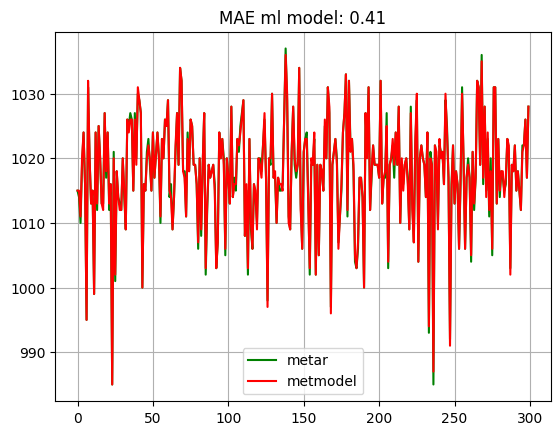

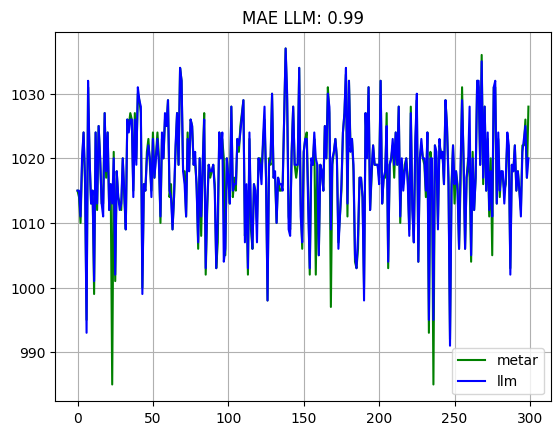

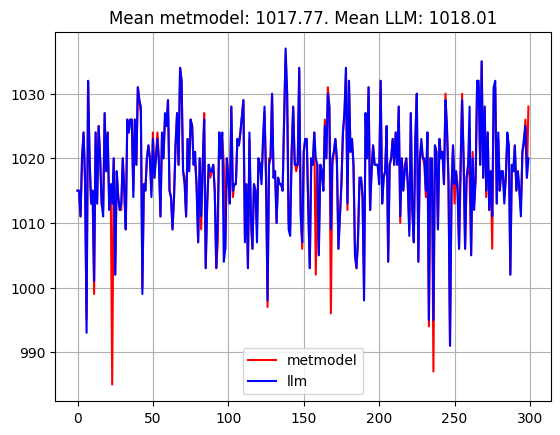

In [3]:
#@title QNH check

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999

score = []

def flatten_list(list_s):
  numbers = []
  for sublist in list_s:
      for item in sublist:
          # Check if the string after 'q' is not empty
          if len(item) > 1:
              num = item[1:]
              if num.isdigit():
                  numbers.append(int(num))


  return np.array(numbers)

df = pd.read_csv(result_path)
q_ytest = []
q_ypred = []
q_metmod =[]
for i in range(0,len(df)):
  q_ytest.append([word for word in df["y_test"][i].split() if 'q' in word.lower()])
  q_ypred.append([word for word in df["y_pred"][i].split() if 'q' in word.lower()][:1])
  q_metmod.append([word for word in df["all"][i].split() if 'q' in word.lower()][:1])

q_ypred_f = []

for sublist in q_ypred:
    if not sublist:  # Check if the sublist is empty
        q_ypred_f.append(["q0000"])
    else:
        q_ypred_f.append(sublist)  # Append the single string element


q_ypred_n = flatten_list(q_ypred_f)
q_test_n = flatten_list(q_ytest)
q_metmod_n = flatten_list(q_metmod)


#Show results
df_res = pd.DataFrame({"metar":q_test_n,"metmodel":q_metmod_n,"llm":q_ypred_n})

#avoid 0
df_res = df_res[df_res.llm!=0]
mae_llm = round((df_res['metar'] - df_res['llm']).abs().mean(),2)
mae_metmod = round(np.mean(np.abs(q_metmod_n - q_test_n)),2)

score.append(mae_llm)
score.append(mae_metmod)

df_res[["metar","metmodel"]].plot(grid=True, color=['green', 'red'],title="MAE ml model: {}".format(mae_metmod));
df_res[["metar","llm"]].plot(grid=True, color=['green', 'blue'],title="MAE LLM: {}".format(mae_llm));
df_res[["metmodel","llm"]].plot(grid=True, color=['red', 'blue'],title="Mean metmodel: {}. Mean LLM: {}".format(round(q_metmod_n.mean(),2),round(df_res.llm.mean(),2)));

In [4]:
#@title wind check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 999

def contains_vrb(column):
    return column.str.contains('VRB', case=False, na=False)

def detect_wind_variation_test(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})V(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1

def detect_wind_variation_llm(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})v(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1


# Function to extract wind direction, speed, and gusts
def extract_wind_llm(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(vrb|\d{3})(\d{2})(g\d{2})?kt\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"


def extract_wind_test(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(VRB|\d{3})(\d{2})(G\d{2})?KT\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"

dirtest, modtest, gtest =[],[],[]
dirllm, modllm, gllm =[],[],[]

df = pd.read_csv(result_path)

for i in range(0,len(df)):
  wind_info_test = extract_wind_test(df["y_test"][i])
  wind_info_llm = extract_wind_llm(df["y_pred"][i])

  if isinstance(wind_info_test, tuple):
    dir, mod, gust = wind_info_test
    dirtest.append(dir)
    modtest.append(mod)
    gtest.append(gust)

  else:
    print(wind_info_test)
    dirtest.append(np.nan)
    modtest.append(np.nan)
    gtest.append(np.nan)

  if isinstance(wind_info_llm, tuple):
    dir, mod, gust = wind_info_llm
    dirllm.append(dir)
    modllm.append(mod)
    gllm.append(gust)

  else:
    print(wind_info_llm,i)
    dirllm.append(np.nan)
    modllm.append(np.nan)
    gllm.append(np.nan)

df["dirtest"]=dirtest
df["modtest"]=modtest
df["gtest"]=gtest

df["dirllm"]=dirllm
df["modllm"]=modllm
df["gllm"]=gllm

for i in range(0,len(df)):
  if "G" in str(df['gtest'][i]):
    df["gtest"][i]= int(df['gtest'][i][1:])

for i in range(0,len(df)):
  if "g" in str(df['gllm'][i]):
    df["gllm"][i]= int(df['gllm'][i][1:])

dirmetmod =[]
for i in range(0,len(df)):
  dirmetmod.append(int(df["all"][i].split()[0][:3]))
df["dirmetmod"] = dirmetmod

modmetmod =[]
for i in range(0,len(df)):
  modmetmod.append(int(df["all"][i].split()[0][3:5]))
df["modmetmod"] = modmetmod

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_test(df["y_test"][i]))
df["dirvartest"] = dirvar

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_llm(df["y_pred"][i]))
df["dirvarllm"] = dirvar
df.set_index("time")

#Analytics
mask_dirtest = contains_vrb(df['dirtest'])
mask_dirllm = contains_vrb(df['dirllm'])

# Combine the masks to filter rows
df_dir = df[~(mask_dirtest | mask_dirllm)][["dirtest","dirllm","dirmetmod"]].dropna().astype(int)

mae = int(np.mean(np.abs(df_dir['dirtest'] - df_dir['dirmetmod'])))
print(f"Mean Absolute Error (degrees) wind direction metmodel and metar: {mae}")
score.append(mae)
#MAE dir no vrb llm metar
mae = int((np.mean(np.abs(df_dir['dirtest'] - df_dir['dirllm']))))
print(f"Mean Absolute Error (degrees) wind direction llm and metar: {mae}")
score.append(mae)
df_mod= df[['modmetmod',"modtest","modllm"]].dropna().astype(int)

mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modmetmod'])),2)
print(f"Mean Absolute Error (Kt) wind intensity metmodel and metar: {mae}")
score.append(mae)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modllm'])),2)
print(f"Mean Absolute Error (kt) wind intensity llm and metar: {mae}")
score.append(mae)

dirvary = sum([1 if (df["dirvarllm"][c][0]!=-1) & (df["dirvartest"][c][0]!=-1) else 0 for c in range(0,len(df))])
dirvarn = sum([1 if (df["dirvarllm"][c][0]==-1) & (df["dirvartest"][c][0]==-1) else 0 for c in range(0,len(df))])
print("Both metar and forecast direction variation:", round(dirvary/len(df),2))
print("Both metar and forecast no direction variation:",round(dirvarn/len(df),2))
print("No match between metar and forecast:", round((len(df)-dirvary-dirvarn)/len(df),2))

display(df.set_index("time")[["dirtest","dirllm","dirmetmod","dirvartest","dirvarllm", "modtest",	"modmetmod","modllm","gtest","gllm"]].head(20))

Wind information not found 247
Mean Absolute Error (degrees) wind direction metmodel and metar: 71
Mean Absolute Error (degrees) wind direction llm and metar: 80
Mean Absolute Error (Kt) wind intensity metmodel and metar: 2.34
Mean Absolute Error (kt) wind intensity llm and metar: 2.74
Both metar and forecast direction variation: 0.45
Both metar and forecast no direction variation: 0.27
No match between metar and forecast: 0.28


,dirtest,dirllm,dirmetmod,dirvartest,dirvarllm,modtest,modmetmod,modllm,gtest,gllm
time,,,,,,,,,,
2021-10-16 15:00:00,160,vrb,170,"(120, 210)","(-1, -1)",05,9,02,0,0
2019-10-28 23:00:00,200,190,180,"(170, 230)","(-1, -1)",05,3,04,0,0
2022-03-07 13:00:00,210,200,190,"(160, 260)","(160, 230)",12,7,13,0,0
2020-08-24 11:00:00,VRB,vrb,60,"(-1, -1)","(-1, -1)",02,3,01,0,0
2018-05-13 09:00:00,270,310,280,"(230, 310)","(250, 010)",08,11,06,0,0
2019-09-19 12:00:00,040,070,20,"(-1, -1)","(010, 110)",05,3,08,0,0
2018-03-06 05:00:00,280,280,260,"(240, 320)","(240, 330)",10,17,12,0,0
2019-03-19 21:00:00,030,360,30,"(340, 060)","(300, 060)",05,5,05,0,0
2018-08-13 20:00:00,360,360,340,"(320, 030)","(320, 050)",04,1,04,0,0


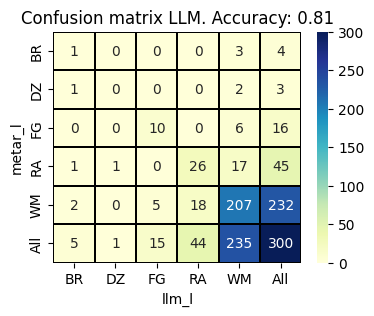

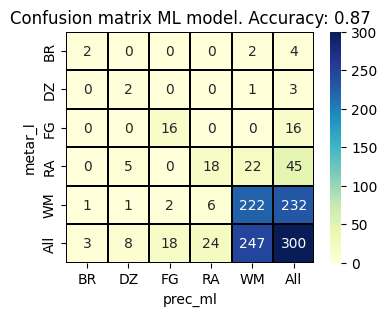

In [5]:
#@title wx check

from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
df = pd.read_csv(result_path)

#label br/fg if weather code contains FG or BR
df["metar_l"] = "WM"
mask = df['y_test'].str.contains("BR")
df.loc[mask,["metar_l"]] = "BR"
mask = df['y_test'].str.contains("FG")
df.loc[mask,["metar_l"]] = "FG"
mask = df['y_test'].str.contains("DZ")
df.loc[mask,["metar_l"]] = "DZ"
mask = df['y_test'].str.contains("RA")
df.loc[mask,["metar_l"]] = "RA"

df["llm_l"] = "WM"
mask = df['y_pred'].str.contains("br")
df.loc[mask,["llm_l"]] = "BR"
mask = df['y_pred'].str.contains("fg")
df.loc[mask,["llm_l"]] = "FG"
mask = df['y_pred'].str.contains("dz")
df.loc[mask,["llm_l"]] = "DZ"
mask = df['y_pred'].str.contains("ra")
df.loc[mask,["llm_l"]] = "RA"



prec_ml =[]
for i in range(0,len(df["all"])):
  prec_ml.append(df["all"][i].split()[2])
df["prec_ml"] = prec_ml


# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df.metar_l, df.llm_l,margins=True)

ac0 = round(accuracy_score(df.metar_l,df.llm_l),2)
score.append(ac0)

cm1 = pd.crosstab(df.metar_l, df.prec_ml,margins=True)
ac1 = round(accuracy_score(df.metar_l,df.prec_ml),2)
score.append(ac1)



plt.figure(figsize=(4, 3))
plt.title("Confusion matrix LLM. Accuracy: {}".format(ac0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix ML model. Accuracy: {}".format(ac1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()


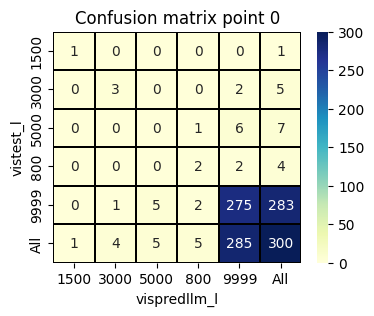


Quality report LLM model
              precision    recall  f1-score     support
1500           1.000000  1.000000  1.000000    1.000000
3000           0.750000  0.600000  0.666667    5.000000
5000           0.000000  0.000000  0.000000    7.000000
800            0.400000  0.500000  0.444444    4.000000
9999           0.964912  0.971731  0.968310  283.000000
accuracy       0.936667  0.936667  0.936667    0.936667
macro avg      0.622982  0.614346  0.615884  300.000000
weighted avg   0.931401  0.936667  0.933809  300.000000
accuracy: 0.9366666666666666


In [6]:
#@title Visibility check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

pd.options.display.max_rows = 999

def extract_visibility(metar):
    # Check if 'CAVOK' is in the METAR report
    if 'CAVOK' in metar:
        return 9999
    if "cavok" in metar:
        return 9999
    # Define a regex pattern for visibility
    visibility_pattern = r'\b(\d{4}|(\d+/\d+)?SM)\b'

    # Search for the visibility in the METAR report
    match = re.search(visibility_pattern, metar)
    if match:
        return int(match.group(0))
    else:
        return "Visibility information not found"

df = pd.read_csv(result_path)

vistest = []
vispred = []
for i in range(0,len(df)):
  vistest.append(extract_visibility(df["y_test"][i]))
  vispred.append(extract_visibility(df["y_pred"][i]))

df["vistest"]= vistest
df["vispred"]= vispred
df[['y_test', 'y_pred', 'all', 'vistest', 'vispred']]


#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,800), (800, 1500),(1500,3000),(3000,5000),(5000,100000)])
labels = ['800', '1500',"3000","5000","9999"]

df["vistest_l"] = pd.cut(df["vistest"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
df["vispredllm_l"] = pd.cut(df["vispred"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
df =df.dropna()
cm0 = pd.crosstab(df.vistest_l, df.vispredllm_l,margins=True)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0")
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

report = classification_report(df.vistest_l,df.vispredllm_l, output_dict=True)

# Convert to DataFrame for easier manipulation (optional)
report_df = pd.DataFrame(report).transpose()

# Extract accuracy
accuracy = report['accuracy']

report = pd.DataFrame(classification_report(df.vistest_l,df.vispredllm_l,output_dict=True)).T
print("\nQuality report LLM model")
print(report)
print("accuracy:",accuracy)
score.append(accuracy)

In [7]:
#@title Temperature check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_temperature_test(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(M?\d{2})/(M?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'M' in temperature:
            temperature = -int(temperature.replace('M', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


def extract_temperature_llm(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(m?\d{2}) (m?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'm' in temperature:
            temperature = -int(temperature.replace('m', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


templlm,tempmetar,tempmetmod, tempmetmodraw =[],[],[],[]
for i in range (0,len(df)):
  tempmetar.append(extract_temperature_test(df["y_test"][i]))
  templlm.append(extract_temperature_llm(df["y_pred"][i]))
  tempmetmodraw.append(df["all"][i].split()[5])

tempmetmod = [-int(temperature.replace('M', '')) if 'M' in temperature else int(temperature) for temperature in tempmetmodraw]
df_temp=pd.DataFrame({"tempmetar":tempmetar,"templlm":templlm,"tempmetmod":tempmetmod}).dropna()


mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['tempmetmod'])),2)
std = round((df_temp['tempmetar'] - df_temp['tempmetmod']).std(),2)
print(f"Mean Absolute Error (degrees) temperature metmodel and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature metmodel and metar: {std}")
score.append(mae)
score.append(std)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['templlm'])),2)
std = round((df_temp['tempmetar'] - df_temp['templlm']).std(),2)
print(f"Mean Absolute Error temperature (degreees) llm and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature LLM and metar: {std}")
score.append(mae)
score.append(std)
df_temp.head(20)

Mean Absolute Error (degrees) temperature metmodel and metar: 0.86
Standard desviation differences (degrees) temperature metmodel and metar: 1.15
Mean Absolute Error temperature (degreees) llm and metar: 1.13
Standard desviation differences (degrees) temperature LLM and metar: 1.45


,tempmetar,templlm,tempmetmod
0,15,16.0,16
1,17,16.0,17
2,14,14.0,13
3,22,24.0,22
4,11,12.0,12
5,25,24.0,24
6,8,6.0,7
7,10,11.0,11
8,18,21.0,19
9,18,18.0,16


In [8]:
#@title Save score

df_score = pd.DataFrame(score,index=["MAE_QNH_llm","MAE_QNH_ml","MAE_dir_metmodel",
                          "MAE_dir_llm","MAE_wind_int_metmodel","MAE_wind_int_llm",
                          "Aaccuracy_wx_llm","Accuracy_wx_ML","accuracy_vis_llm","MAE_temp_ml","Std_temp_diff_ml",
                          "MAE_temp_llm","Std_temp_diff_llm"], columns=["Score"])
score_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/algorithms/LECOmlscore.csv"
df_score.to_csv(score_path)

In [ ]:
df_score

,Score
MAE_QNH_llm,0.540000
MAE_QNH_ml,0.350000
MAE_dir_metmodel,50.000000
MAE_dir_llm,52.000000
MAE_wind_int_metmodel,3.840000
MAE_wind_int_llm,2.190000
Aaccuracy_wx_llm,0.770000
Accuracy_wx_ML,0.800000
accuracy_vis_llm,0.886667
MAE_temp_ml,0.720000
